# Train 1D CNN

1D Convolution을 기본 구성 요소로 하는 EEG classifier를 학습해보는 노트북.

- Two binary classification using sigmoid
    - Binary classification of normal and non-vascular {MCI or dementia}
    - Binary classification of non-vascular MCI and non-vascular dementia

-----

## 환경 구성

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load some packages
import os
import glob
import json
import datetime

import matplotlib.pyplot as plt
import pprint
from IPython.display import clear_output
from tqdm.auto import tqdm

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from typing import Type, Any, Callable, Union, List, Optional

# custom package
from utils.eeg_dataset import *

In [3]:
# Other settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # cleaner text

plt.style.use('default') 
# ['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 
#  'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 
#  'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 
#  'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 
#  'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams["font.family"] = 'NanumGothic' # for Hangul in Windows

In [4]:
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.')

PyTorch version: 1.9.0
cuda is available.


In [5]:
# Data file path
root_path = r'dataset/02_Curated_Data/'

In [6]:
meta_path = os.path.join(root_path, 'metadata_debug.json')
with open(meta_path, 'r') as json_file:
    metadata = json.load(json_file)

pprint.pprint(metadata[0])

{'age': 78,
 'birth': '1940-06-02',
 'dx1': 'mci_rf',
 'edfname': '00001809_261018',
 'events': [[0, 'Start Recording'],
            [0, 'New Montage - Montage 002'],
            [36396, 'Eyes Open'],
            [72518, 'Eyes Closed'],
            [73862, 'Eyes Open'],
            [75248, 'Eyes Closed'],
            [76728, 'swallowing'],
            [77978, 'Eyes Open'],
            [79406, 'Eyes Closed'],
            [79996, 'Photic On - 3.0 Hz'],
            [80288, 'Eyes Open'],
            [81296, 'Eyes Closed'],
            [82054, 'Photic Off'],
            [84070, 'Photic On - 6.0 Hz'],
            [84488, 'Eyes Open'],
            [85538, 'Eyes Closed'],
            [86086, 'Photic Off'],
            [88144, 'Photic On - 9.0 Hz'],
            [90160, 'Photic Off'],
            [91458, 'Eyes Open'],
            [92218, 'Photic On - 12.0 Hz'],
            [92762, 'Eyes Closed'],
            [94198, 'Photic Off'],
            [94742, 'Eyes Open'],
            [95708, 'Eyes Close

-----

## Data Filtering by Diagnosis

#### Non-Vascular Dementia, Non-Vascular MCI, Normal

In [7]:
diagnosis_filter = [
    # Normal
    {'type': 'Normal',
     'include': ['normal'], 
     'exclude': []},
    # Non-vascular MCI
    {'type': 'Non-vascular MCI',
     'include': ['mci'], 
     'exclude': ['mci_vascular']},
    # Non-vascular dementia
    {'type': 'Non-vascular dementia',
     'include': ['dementia'], 
     'exclude': ['vd']},
]


def generate_class_label(label):
    for c, f in enumerate(diagnosis_filter):
        inc = set(f['include']) & set(label) == set(f['include'])
        # inc = len(set(f['include']) & set(label)) > 0        
        exc = len(set(f['exclude']) & set(label)) == 0
        if  inc and exc:
            return (c, f['type'])
    return (-1, 'The others')


class_label_to_type = [d_f['type'] for d_f in diagnosis_filter]
print('class_label_to_type:', class_label_to_type)

class_label_to_type: ['Normal', 'Non-vascular MCI', 'Non-vascular dementia']


In [8]:
def class_label_to_target(c):
    # Normal
    if c == 0: 
        return (0, -1)
    # Non-vascular MCI
    elif c == 1: 
        return (1, 0)
    # Dementia
    elif c == 2:
        return (1, 1)
    else:
        raise ValueError('Input class label is out of range.')
    
    
def target_to_class_label(target):
    # Normal
    if target[0] == 0:
        return 0
    # Non-vascular MCI
    elif target == (1, 0):
        return 1
    # Dementia
    elif target == (1, 1):
        return 2
    else:
        raise ValueError('Input target is out of range.')

In [9]:
splitted_metadata = [[] for i in diagnosis_filter]

for m in metadata:
    c, n = generate_class_label(m['label'])
    if c >= 0:
        m['class_type'] = n
        m['class_label'] = class_label_to_target(c)
        splitted_metadata[c].append(m)
        
for i, split in enumerate(splitted_metadata):
    if len(split) == 0:
        print(f'(Warning) Split group {i} has no data.')
    else:
        print(f'- There are {len(split):} data belonging to {split[0]["class_type"]}')

- There are 463 data belonging to Normal
- There are 347 data belonging to Non-vascular MCI
- There are 229 data belonging to Non-vascular dementia


-----

## Configure the Train, Validation, and Test Splits

#### Split the filtered dataset and shuffle them

In [9]:
# random seed
random.seed(0)

# Train : Val : Test = 8 : 1 : 1
ratio1 = 0.8
ratio2 = 0.1

metadata_train = []
metadata_val = []
metadata_test = []

for split in splitted_metadata:
    random.shuffle(split)
    
    n1 = round(len(split) * ratio1)
    n2 = n1 + round(len(split) * ratio2)

    metadata_train.extend(split[:n1])
    metadata_val.extend(split[n1:n2])
    metadata_test.extend(split[n2:])

random.shuffle(metadata_train)
random.shuffle(metadata_val)
random.shuffle(metadata_test)

print('Train data size\t\t:', len(metadata_train))
print('Validation data size\t:', len(metadata_val))
print('Test data size\t\t:', len(metadata_test))

print('\n', '--- Recheck ---', '\n')
train_class_nums = np.zeros((len(class_label_to_type)), dtype=np.int32)
for m in metadata_train:
    train_class_nums[target_to_class_label(m['class_label'])] += 1

val_class_nums = np.zeros((len(class_label_to_type)), dtype=np.int32)
for m in metadata_val:
    val_class_nums[target_to_class_label(m['class_label'])] += 1

test_class_nums = np.zeros((len(class_label_to_type)), dtype=np.int32)
for m in metadata_test:
    test_class_nums[target_to_class_label(m['class_label'])] += 1

print('Train data label distribution\t:', train_class_nums, train_class_nums.sum())
print('Val data label distribution\t:', val_class_nums, val_class_nums.sum())
print('Test data label distribution\t:', test_class_nums, test_class_nums.sum())

# random seed
random.seed()

# print([m['serial']  for m in metadata_train[:15]])
# print([m['serial']  for m in metadata_val[:15]])
# print([m['serial']  for m in metadata_test[:15]])

Train data size		: 831
Validation data size	: 104
Test data size		: 104

 --- Recheck --- 

Train data label distribution	: [370 278 183] 831
Val data label distribution	: [46 35 23] 104
Test data label distribution	: [47 34 23] 104


#### Wrap the splitted data using PyTorch Dataset

In [10]:
ages = []
for m in metadata_train:
    ages.append(m['age'])

ages = np.array(ages)
age_mean = np.mean(ages)
age_std = np.std(ages)

print('Age mean and standard deviation:')
print(age_mean, age_std)

Age mean and standard deviation:
69.92779783393502 9.817569889945597


In [11]:
composed = transforms.Compose([EEGNormalizeAge(mean=age_mean, std=age_std),
                               EEGDropPhoticChannel(),
                               EEGRandomCrop(crop_length=200*60), # 1 minutes
                               EEGNormalizePerSignal(),
                               EEGToTensor()])

train_dataset = EEGDataset(root_path, metadata_train, composed)
val_dataset = EEGDataset(root_path, metadata_val, composed)
test_dataset = EEGDataset(root_path, metadata_test, composed)

print(train_dataset[0]['signal'].shape)
print(train_dataset[0])

print()
print('-' * 100)
print()

print(val_dataset[0]['signal'].shape)
print(val_dataset[0])

print()
print('-' * 100)
print()

print(test_dataset[0]['signal'].shape)
print(test_dataset[0])

torch.Size([20, 12000])
{'signal': tensor([[-0.3327, -0.3858, -0.4036,  ...,  0.9082,  0.9437,  0.9791],
        [-0.7782, -0.8084, -0.7782,  ...,  1.2414,  1.1510,  1.0304],
        [-0.1685, -0.1685, -0.1271,  ..., -0.3135, -0.3135, -0.3342],
        ...,
        [ 0.8853,  0.7820,  0.7820,  ...,  0.2654,  0.0587, -0.1479],
        [ 0.4032,  0.4771,  0.4032,  ..., -1.1495, -1.2234, -1.2973],
        [ 0.2402,  0.2539,  0.3498,  ...,  0.8776,  0.6514,  0.5760]]), 'age': tensor(-1.2149), 'class_label': tensor([ 0, -1]), 'metadata': {'serial': '01012', 'edfname': '01212635_270515', 'birth': '1956-06-01', 'record': '2015-05-27T09:37:24', 'age': 58, 'dx1': 'cb_normal', 'label': ['normal', 'cb_normal'], 'events': [[0, 'Start Recording'], [0, 'New Montage - Montage 002'], [400, 'Eyes Open'], [7918, 'Eyes Closed'], [14091, 'Eyes Open'], [18208, 'Eyes Closed'], [24256, 'Eyes Open'], [30724, 'Eyes Closed'], [36562, 'Eyes Open'], [42190, 'Eyes Closed'], [48910, 'Eyes Open'], [55126, 'Eyes Clos

#### Data loader test

In [12]:
print('Current PyTorch device:', device)
if device.type == 'cuda':
    num_workers = 0 # A number other than 0 causes an error
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = DataLoader(train_dataset, 
                          batch_size=32, 
                          shuffle=True, 
                          drop_last=True,
                          num_workers=num_workers, 
                          pin_memory=pin_memory,
                          collate_fn=eeg_collate_fn)

for i_batch, sample_batched in enumerate(train_loader):
    sample_batched['signal'].to(device)
    sample_batched['age'].to(device)
    sample_batched['class_label'].to(device)
    
    print(i_batch, 
          sample_batched['signal'].shape, 
          sample_batched['age'].shape, 
          sample_batched['class_label'].shape, 
          len(sample_batched['metadata']))
    
    if i_batch > 3:
        break

Current PyTorch device: cuda
0 torch.Size([32, 20, 12000]) torch.Size([32]) torch.Size([32, 2]) 32
1 torch.Size([32, 20, 12000]) torch.Size([32]) torch.Size([32, 2]) 32
2 torch.Size([32, 20, 12000]) torch.Size([32]) torch.Size([32, 2]) 32
3 torch.Size([32, 20, 12000]) torch.Size([32]) torch.Size([32, 2]) 32
4 torch.Size([32, 20, 12000]) torch.Size([32]) torch.Size([32, 2]) 32


#### Train, validation, test dataloaders

In [13]:
train_loader = DataLoader(train_dataset, 
                          batch_size=32, 
                          shuffle=True, 
                          drop_last=True,
                          num_workers=num_workers, 
                          pin_memory=pin_memory,
                          collate_fn=eeg_collate_fn)

val_loader = DataLoader(val_dataset, 
                        batch_size=32, 
                        shuffle=False, 
                        drop_last=False,
                        num_workers=num_workers, 
                        pin_memory=pin_memory,
                        collate_fn=eeg_collate_fn)

test_loader = DataLoader(test_dataset, 
                         batch_size=32, 
                         shuffle=False, 
                         drop_last=False,
                         num_workers=num_workers, 
                         pin_memory=pin_memory,
                         collate_fn=eeg_collate_fn)

-----

## Some useful functions for training

In [14]:
from torch.utils.tensorboard import SummaryWriter
import ipynbname
nb_fname = ipynbname.name()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def visualize_network_tensorboard(model, name):
    # default `log_dir` is "runs" - we'll be more specific here
    writer = SummaryWriter('runs/' + nb_fname + '_' + name)

    for batch_i, sample_batched in enumerate(train_loader):
        # pull up the batch data
        x = sample_batched['signal'].to(device)
        age = sample_batched['age'].to(device)
        target = sample_batched['class_label'].to(device)

        # apply model on whole batch directly on device
        writer.add_graph(model, (x, age))
        output = model(x, age, print_shape=True)
        break
        
    writer.close()

In [15]:
def train_one_epoch(model, optimizer, log_interval):
    # turn the models to training mode
    model.train()
    losses = []
    
    correct1, total1 = (0, 0)
    correct2, total2 = (0, 0)    

    train_confusion1 = np.zeros((2, 2), dtype=np.int32)
    train_confusion2 = np.zeros((2, 2), dtype=np.int32)
    
    for batch_i, sample_batched in enumerate(train_loader):
        # pull up the batch data
        x = sample_batched['signal'].to(device)
        age = sample_batched['age'].to(device)
        target = sample_batched['class_label'].type(x.type()).to(device)
        
        target1 = target[:, 0]
        mask = target[:, 0] > 0.5
        target2 = target[mask, 1]
                
        # apply model on whole batch directly on device        
        output = model(x, age)
        output1 = output[:, 0]
        output2 = output[mask, 1]
        
        # binary cross-entropy loss 1: Normal vs (MCI, dementia)
        loss1 = F.binary_cross_entropy_with_logits(output1, target1)
        
        # binary cross-entropy loss 2: MCI vs dementia
        loss2 = F.binary_cross_entropy_with_logits(output2, target2)
        
        # total loss
        loss = loss1 + loss2
        
        # backprop and update
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # record loss
        losses.append(loss.item())

        # train accuracy
        pred1 = output1 > 0.5
        correct1 += pred1.eq(target1).sum().item()
        total1 += pred1.shape[0]

        pred2 = output2 > 0.5
        correct2 += pred2.eq(target2).sum().item()
        total2 += pred2.shape[0]
        
        # confusion matrix
        train_confusion1 += calculate_confusion_matrix(pred1.type(dtype=torch.int32), 
                                                       target1.type(dtype=torch.int32))
        train_confusion2 += calculate_confusion_matrix(pred2.type(dtype=torch.int32),
                                                       target2.type(dtype=torch.int32))
        
        # print training stats
        if log_interval is not None and (batch_i + 1) % log_interval == 0:
            print(f'- Iter {batch_i + 1:03d} / {len(train_loader):03d}, Loss: {loss.item():.06f}')
    
    train_accuracy1 = 100.0 * correct1 / total1
    train_accuracy2 = 100.0 * correct2 / total2
    
    return losses, (train_accuracy1, train_accuracy2), (train_confusion1, train_confusion2)


def check_val_accuracy(model, repeat=1):
    model.eval()
    correct1, total1 = (0, 0)
    correct2, total2 = (0, 0)    

    val_confusion1 = np.zeros((2, 2), dtype=np.int32)
    val_confusion2 = np.zeros((2, 2), dtype=np.int32)

    with torch.no_grad():
        for k in range(repeat):
            for sample_batched in val_loader:
                # pull up the data
                x = sample_batched['signal'].to(device)
                age = sample_batched['age'].to(device)
                target = sample_batched['class_label'].to(device)

                target1 = target[:, 0]
                mask = target[:, 0] > 0.5
                target2 = target[mask, 1]

                # apply model on whole batch directly on device
                output = model(x, age)
                output1 = output[:, 0]
                output2 = output[mask, 1]

                # val accuracy
                pred1 = output1 > 0.5
                correct1 += pred1.eq(target1).sum().item()
                total1 += pred1.shape[0]

                pred2 = output2 > 0.5
                correct2 += pred2.eq(target2).sum().item()
                total2 += pred2.shape[0]

                # confusion matrix
                val_confusion1 += calculate_confusion_matrix(pred1, target1)
                val_confusion2 += calculate_confusion_matrix(pred2, target2)
            
    val_accuracy1 = 100.0 * correct1 / total1
    val_accuracy2 = 100.0 * correct2 / total2

    return (val_accuracy1, val_accuracy2), (val_confusion1, val_confusion2)

    
def check_test_accuracy(model, repeat=1):
    model.eval()
    correct1, total1 = (0, 0)
    correct2, total2 = (0, 0)    

    test_confusion1 = np.zeros((2, 2), dtype=np.int32)
    test_confusion2 = np.zeros((2, 2), dtype=np.int32)
    
    test_debug = {data['metadata']['serial']: 
                  {'GT': data['class_label'].numpy().tolist(),
                   'Acc1': 0, 
                   'Acc2': 0,
                   'Pred1': [0] * 2,
                   'Pred2': [0] * 2} for data in test_dataset}
    
    with torch.no_grad():
        for k in range(repeat):
            for sample_batched in test_loader:
                # pull up the data
                x = sample_batched['signal'].to(device)
                age = sample_batched['age'].to(device)
                target = sample_batched['class_label'].to(device)

                target1 = target[:, 0]
                mask = target[:, 0] > 0.5
                target2 = target[mask, 1]

                # apply model on whole batch directly on device
                output = model(x, age)
                output1 = output[:, 0]
                output2 = output[mask, 1]

                # test accuracy
                pred1 = output1 > 0.5
                correct1 += pred1.eq(target1).sum().item()
                total1 += pred1.shape[0]

                pred2 = output2 > 0.5
                correct2 += pred2.eq(target2).sum().item()
                total2 += pred2.shape[0]

                # confusion matrix
                test_confusion1 += calculate_confusion_matrix(pred1, target1)
                test_confusion2 += calculate_confusion_matrix(pred2, target2)

                # test debug
                for n in range(pred1.shape[0]):
                    serial = sample_batched['metadata'][n]['serial']
                    test_debug[serial]['edfname'] = sample_batched['metadata'][n]['edfname']
                    test_debug[serial]['Pred1'][pred1[n].item()] += 1
                    acc1 = test_debug[serial]['Pred1'][target1[n].item()] \
                            / np.sum(test_debug[serial]['Pred1']) * 100
                    test_debug[serial]['Acc1'] = f'{acc1:>6.02f}%'

                    if mask[n] == True:
                        test_debug[serial]['Pred2'][(output[n, 1] > 0.5).item()] += 1
                        acc2 = test_debug[serial]['Pred2'][target[n, 1].item()] \
                                / np.sum(test_debug[serial]['Pred2']) * 100
                        test_debug[serial]['Acc2'] = f'{acc2:>6.02f}%'
        
    test_accuracy1 = 100.0 * correct1 / total1
    test_accuracy2 = 100.0 * correct2 / total2

    return (test_accuracy1, test_accuracy2), (test_confusion1, test_confusion2), test_debug


def calculate_confusion_matrix(pred, target):
    N = target.shape[0]
    confusion = np.zeros((2, 2), dtype=np.int32)
    
    for i in range(N):
        r = target[i]
        c = pred[i]
        confusion[r, c] += 1
    return confusion

In [16]:
def draw_loss_plot(loss_history):
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic
    fig = plt.figure(num=1, clear=True, figsize=(15.0, 6.0), constrained_layout=True)
    
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(loss_history)
    ax.vlines(0, 0, 1, transform=ax.get_xaxis_transform(), colors='k', alpha=0.1)    
    for e in range(1, n_epoch + 1):        
        if e % lr_schedule_step == 0:
            ax.vlines(e*len(train_loader) - 1, 0, 1, transform=ax.get_xaxis_transform(), colors='m', alpha=0.3)
        else:
            ax.vlines(e*len(train_loader) - 1, 0, 1, transform=ax.get_xaxis_transform(), colors='k', alpha=0.1)    
    ax.set_title('Loss Plot')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Training Loss')

    plt.show()
    fig.clear()
    plt.close(fig)


def draw_accuracy_history(train_acc_history, val_acc_history):
    train_acc_history1, train_acc_history2 = train_acc_history
    val_acc_history1, val_acc_history2 = val_acc_history
    
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic
    fig = plt.figure(num=1, clear=True, figsize=(15.0, 12.0), constrained_layout=True)

    ax = fig.add_subplot(2, 1, 1)
    ax.plot(train_acc_history1, 'r-', label='Train accuracy')
    ax.plot(val_acc_history1, 'b-', label='Validation accuracy')
    ax.legend(loc='lower right')    
    ax.set_title('Accuracy 1 Plot during Training')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')

    ax = fig.add_subplot(2, 1, 2)
    ax.plot(train_acc_history2, 'r-', label='Train accuracy')
    ax.plot(val_acc_history2, 'b-', label='Validation accuracy')
    ax.legend(loc='lower right')    
    ax.set_title('Accuracy 2 Plot during Training')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    
    plt.show()
    fig.clear()
    plt.close(fig)


def draw_confusion(confusion):
    confusion1, confusion2 = confusion
    
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic
    plt.rcParams['image.cmap'] = 'jet' # 'nipy_spectral'

    fig = plt.figure(num=1, clear=True, figsize=(5.0, 5.0), constrained_layout=True)
    
    ax = fig.add_subplot(2, 1, 1)
    im = ax.imshow(confusion1, alpha=0.8)

    ax.set_xticks(np.arange(2))
    ax.set_yticks(np.arange(2))
    ax.set_xticklabels(['Normal', 'MCI or Dementia'])
    ax.set_yticklabels(['Normal', 'MCI or Dementia'])
    
    for r in range(2):
        for c in range(2):
            text = ax.text(c, r, confusion1[r, c],
                           ha="center", va="center", color='k')
    
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Ground Truth')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    ax = fig.add_subplot(2, 1, 2)
    im = ax.imshow(confusion2, alpha=0.8)

    ax.set_xticks(np.arange(2))
    ax.set_yticks(np.arange(2))
    ax.set_xticklabels(['MCI', 'Dementia'])
    ax.set_yticklabels(['MCI', 'Dementia'])
    
    for r in range(2):
        for c in range(2):
            text = ax.text(c, r, confusion2[r, c],
                           ha="center", va="center", color='k')
    
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Ground Truth')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    plt.show()
    fig.clear()
    plt.close(fig)

In [17]:
def learning_rate_search(model, min_log_lr, max_log_lr, trials, epochs):
    learning_rate_record = []
    for t in tqdm(range(trials)):
        log_lr = np.random.uniform(min_log_lr, max_log_lr)
        lr = 10 ** log_lr
        
        model.reset_weights()
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0001)

        for e in range(epochs):
            _, (train_accuracy1, train_accuracy2), _ = train_one_epoch(model, optimizer, log_interval=None)
        
        # Train accuracy for the final epoch is stored
        learning_rate_record.append((log_lr, (train_accuracy1, train_accuracy2)))
    
    return learning_rate_record


def draw_learning_rate_record(learning_rate_record):
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic

    fig = plt.figure(num=1, clear=True, figsize=(8.0, 8.0), constrained_layout=True)
    
    ax = fig.add_subplot(2, 1, 1)
    ax.set_title('Learning Rate Search')
    ax.set_xlabel('Learning rate in log-scale')
    ax.set_ylabel('Train accuracy 1')
    
    for log_lr, (accuracy1, _) in learning_rate_record:
        ax.scatter(log_lr, accuracy1, c='r',
                   alpha=0.5, edgecolors='none')

    ax = fig.add_subplot(2, 1, 2)
    ax.set_title('Learning Rate Search')
    ax.set_xlabel('Learning rate in log-scale')
    ax.set_ylabel('Train accuracy 2')
    
    for log_lr, (_, accuracy2) in learning_rate_record:
        ax.scatter(log_lr, accuracy2, c='r',
                   alpha=0.5, edgecolors='none')
        
    plt.show()
    fig.clear()
    plt.close(fig)

-----

## Train 1D CNN models

#### 1D CNN: Tiny model

In [18]:
class TinyNet(nn.Module):
    def __init__(self, n_input=20, n_output=3, stride=7, n_channel=64, 
                 use_age=True, final_pool='average'):
        super().__init__()
        
        if final_pool not in {'average', 'max'}:
            raise ValueError("final_pool must be set to one of ['average', 'max']")
        
        self.use_age = use_age
        
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=35, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=7)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(2)

        if final_pool == 'average':
            self.final_pool = nn.AdaptiveAvgPool1d(1)
        elif final_pool == 'max':
            self.final_pool = nn.AdaptiveMaxPool1d(1)
            
        if self.use_age:        
            self.fc1 = nn.Linear(n_channel + 1, n_channel)
        else:
            self.fc1 = nn.Linear(n_channel, n_channel)
            
        self.dropout = nn.Dropout(p=0.3)
        self.bnfc1 = nn.BatchNorm1d(n_channel)
        self.fc2 = nn.Linear(n_channel, n_output)
        
    def reset_weights(self):
        for m in self.modules():
            if hasattr(m, 'reset_parameters'):
                m.reset_parameters()

    def forward(self, x, age, print_shape=False):
        # conv-bn-relu-pool 
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)

        if print_shape:
            print('Shape right before squeezing:', x.shape)

        x = self.final_pool(x).squeeze()
        if self.use_age:
            x = torch.cat((x, age.reshape(-1, 1)), dim=1)

        # fc-bn-dropout-relu-fc
        x = self.fc1(x)
        x = self.bnfc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x
        # return F.log_softmax(x, dim=1)

In [19]:
model = TinyNet(n_input=train_dataset[0]['signal'].shape[0], 
                n_output=2, 
                use_age=True, 
                final_pool='max')

model = model.to(device, dtype=torch.float32)
print(model)
print()

# tensorboard visualization
visualize_network_tensorboard(model, 'TinyNet')

# number of parameters
n = count_parameters(model)
print(f'The Number of parameters of the model: {n:,}')

TinyNet(
  (conv1): Conv1d(20, 64, kernel_size=(35,), stride=(7,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(7,), stride=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (final_pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=65, out_features=64, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (bnfc1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)



C:\Users\IPIS-Minjae\anaconda3\envs\EEG_Project\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


The Number of parameters of the model: 78,338


In [20]:
# record = learning_rate_search(model, 
#                               min_log_lr=-4.5, 
#                               max_log_lr=-1.4, 
#                               trials=500, 
#                               epochs=3)
# draw_learning_rate_record(record)
# best_log_lr = record[np.argmax(np.array([v for lr, v in record]))][0]

best_log_lr = -3.5
print('best_log_lr:', best_log_lr)

best_log_lr: -3.5


**************************************** Training Starts ****************************************


  0%|          | 0/500 [00:00<?, ?it/s]

------------------------------ Epoch 001 / 500, Learning rate: 3.16e-04 ------------------------------
- Iter 012 / 025, Loss: 1.468628
- Iter 024 / 025, Loss: 1.314378

* Train accuracy: 47.50% / 58.56%, 
* Val   accuracy: 47.12% / 62.07%

------------------------------ Epoch 002 / 500, Learning rate: 3.16e-04 ------------------------------
- Iter 012 / 025, Loss: 1.486454
- Iter 024 / 025, Loss: 1.186596

* Train accuracy: 49.25% / 60.18%, 
* Val   accuracy: 42.31% / 58.62%

------------------------------ Epoch 003 / 500, Learning rate: 3.16e-04 ------------------------------
- Iter 012 / 025, Loss: 1.301521
- Iter 024 / 025, Loss: 1.371294

* Train accuracy: 51.12% / 61.07%, 
* Val   accuracy: 49.04% / 58.62%

------------------------------ Epoch 004 / 500, Learning rate: 3.16e-04 ------------------------------
- Iter 012 / 025, Loss: 1.267074
- Iter 024 / 025, Loss: 1.352818

* Train accuracy: 51.38% / 61.00%, 
* Val   accuracy: 54.81% / 60.34%

------------------------------ Epoch

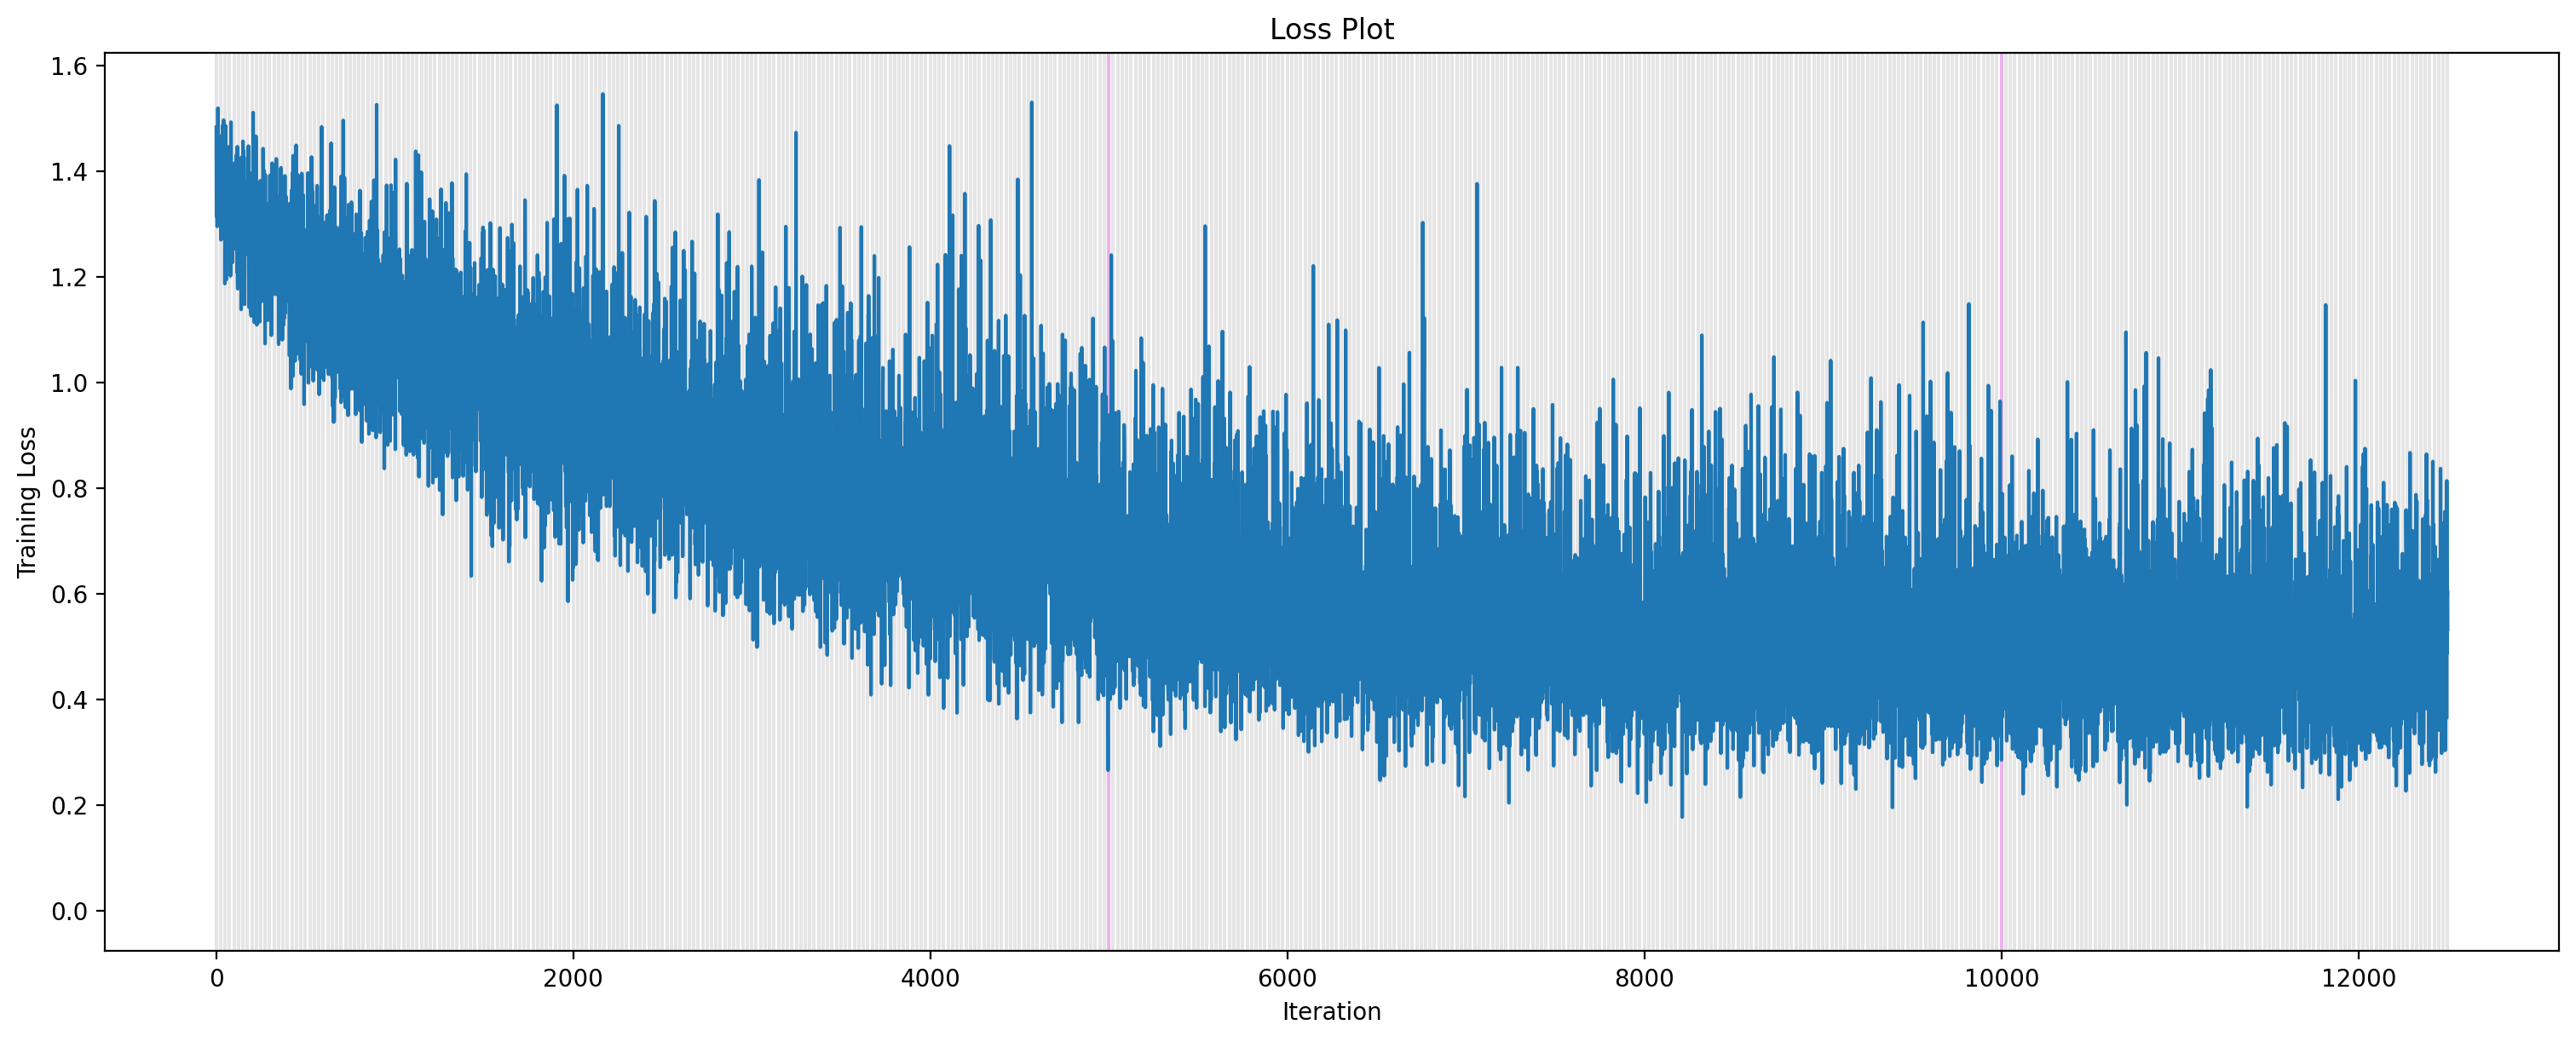

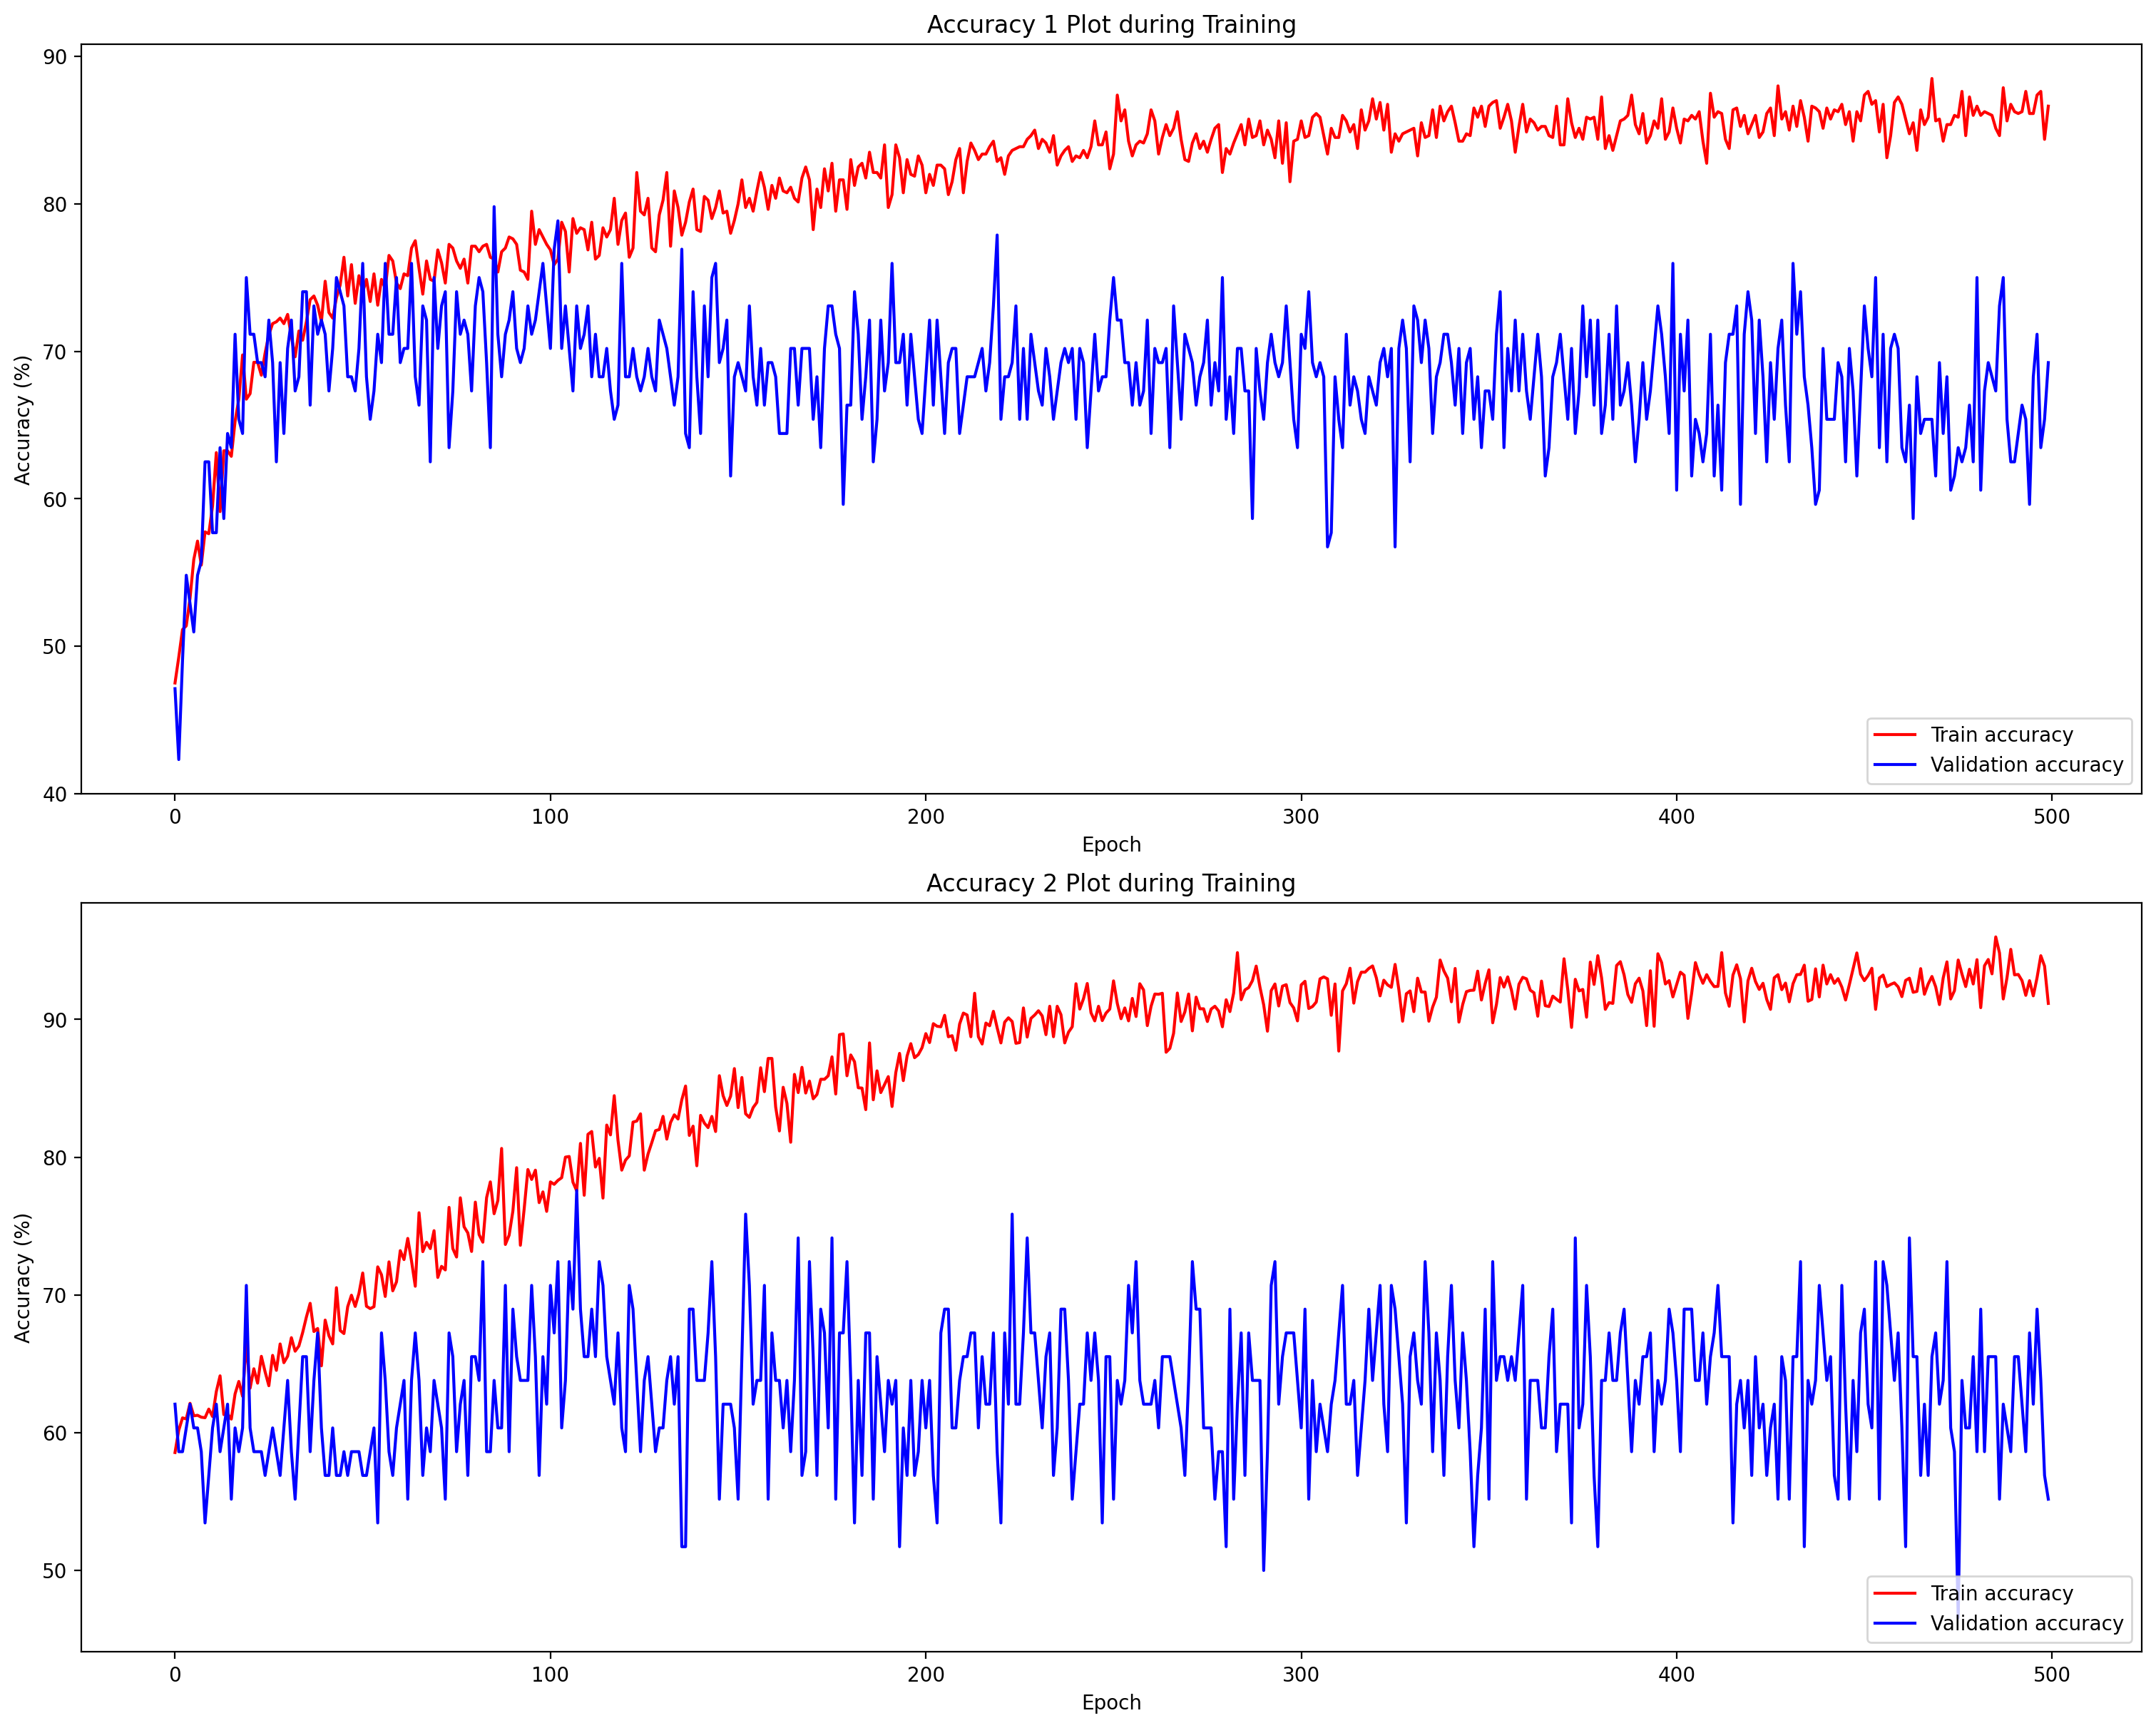

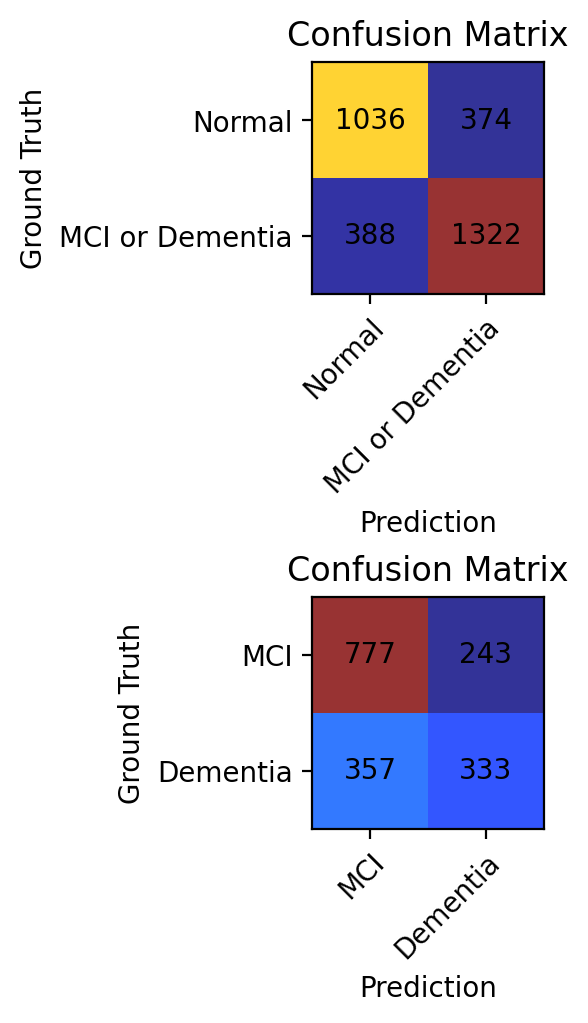

In [21]:
# reduce the learning after [lr_schedule_step] epochs by a factor of 10
n_epoch = 500
lr_schedule_step = 200
log_interval = len(train_loader) // 2

loss_history = []
train_acc_history = ([], [])
val_acc_history = ([], [])

model.reset_weights()
optimizer = optim.AdamW(model.parameters(), lr=10 ** best_log_lr, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_schedule_step, gamma=0.1)

print(f'{"*"*40} Training Starts {"*"*40}')

for epoch in tqdm(range(1, n_epoch + 1)):
    print(f'{"-"*30} Epoch {epoch:03d} / {n_epoch:03d}, Learning rate: {optimizer.param_groups[-1]["lr"]:.2e} {"-"*30}')
    
    # train
    loss, train_accuracy, train_confusion = train_one_epoch(model, optimizer, log_interval)
    loss_history.extend(loss)
    train_acc_history[0].append(train_accuracy[0])
    train_acc_history[1].append(train_accuracy[1])
    
    # validation
    val_accuracy, val_confusion = check_val_accuracy(model)
    val_acc_history[0].append(val_accuracy[0])
    val_acc_history[1].append(val_accuracy[1])
    
    # learning rate schedule
    scheduler.step()
    
    print()
    print(f'* Train accuracy: {train_accuracy[0]:.2f}% / {train_accuracy[1]:.2f}%, ')
    print(f'* Val   accuracy: {val_accuracy[0]:.2f}% / {val_accuracy[1]:.2f}%')
    print()
    
# test
test_accuracy, test_confusion, test_debug = check_test_accuracy(model, repeat=30)

print(f'{"*"*40} Training Ends {"*"*40}')
print(f'- Test accuracy: {test_accuracy:.2f}%')
print()
print('- Confusion matrix:\n', test_confusion)
print()

# draw the training loss plot
draw_loss_plot(loss_history)
draw_accuracy_history(train_acc_history, val_acc_history)

# draw the confusion matrix
draw_confusion(test_confusion)

In [ ]:
print('- Debug table:')
pprint.pp(test_debug, indent=2, width=100)

#### 1D CNN: M5-like model

In [22]:
class M5(nn.Module):
    def __init__(self, n_input=20, n_output=3, stride=4, n_channel=256, 
                 use_age=True, final_pool='average'):
        super().__init__()
        
        if final_pool not in {'average', 'max'}:
            raise ValueError("final_pool must be set to one of ['average', 'max']")
        
        self.use_age = use_age
        
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=41, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=11)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(2)
        
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=11)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(2)
        
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=11)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(2)
        
        self.conv5 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=11)
        self.bn5 = nn.BatchNorm1d(2 * n_channel)
        self.pool5 = nn.MaxPool1d(2)
        
        if final_pool == 'average':
            self.final_pool = nn.AdaptiveAvgPool1d(1)
        elif final_pool == 'max':
            self.final_pool = nn.AdaptiveMaxPool1d(1)
            
        if self.use_age:        
            self.fc1 = nn.Linear(2 * n_channel + 1, 2 * n_channel)
        else:
            self.fc1 = nn.Linear(2 * n_channel, 2 * n_channel)
            
        self.dropout = nn.Dropout(p=0.3)
        self.bnfc1 = nn.BatchNorm1d(2 * n_channel)
        self.fc2 = nn.Linear(2 * n_channel, n_output)
        
    def reset_weights(self):
        for m in self.modules():
            if hasattr(m, 'reset_parameters'):
                m.reset_parameters()

    def forward(self, x, age, print_shape=False):
        # conv-bn-relu-pool 
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)

        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)

        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.pool5(x)

        if print_shape:
            print('Shape right before squeezing:', x.shape)

        x = self.final_pool(x).squeeze()
        if self.use_age:
            x = torch.cat((x, age.reshape(-1, 1)), dim=1)

        # fc-bn-dropout-relu-fc
        x = self.fc1(x)
        x = self.bnfc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x
        # return F.log_softmax(x, dim=1)

In [23]:
model = M5(n_input=train_dataset[0]['signal'].shape[0], 
           n_output=2, 
           use_age=True, 
           final_pool='max')

model = model.to(device, dtype=torch.float32)
print(model)
print()

# tensorboard visualization
visualize_network_tensorboard(model, 'M5-like')

# number of parameters
n = count_parameters(model)
print(f'The Number of parameters of the model: {n:,}')

M5(
  (conv1): Conv1d(20, 256, kernel_size=(41,), stride=(4,))
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(256, 256, kernel_size=(11,), stride=(1,))
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(256, 512, kernel_size=(11,), stride=(1,))
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(512, 512, kernel_size=(11,), stride=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv1d(512, 512, kernel_size=(11,), stride

In [24]:
# record = learning_rate_search(model, 
#                               min_log_lr=-4.5, 
#                               max_log_lr=-1.4, 
#                               trials=500, 
#                               epochs=3)
# draw_learning_rate_record(record)
# best_log_lr = record[np.argmax(np.array([v for lr, v in record]))][0]

best_log_lr = -3.5
print('best_log_lr:', best_log_lr)

best_log_lr: -3.5


**************************************** Training Starts ****************************************


  0%|          | 0/500 [00:00<?, ?it/s]

------------------------------ Epoch 001 / 500, Learning rate: 3.16e-04 ------------------------------
- Iter 012 / 025, Loss: 1.498917
- Iter 024 / 025, Loss: 1.289933

* Train accuracy: 46.88% / 58.14%, 
* Val   accuracy: 52.88% / 56.90%

------------------------------ Epoch 002 / 500, Learning rate: 3.16e-04 ------------------------------
- Iter 012 / 025, Loss: 1.298627
- Iter 024 / 025, Loss: 1.396448

* Train accuracy: 52.00% / 61.49%, 
* Val   accuracy: 61.54% / 56.90%

------------------------------ Epoch 003 / 500, Learning rate: 3.16e-04 ------------------------------
- Iter 012 / 025, Loss: 1.400140
- Iter 024 / 025, Loss: 1.270139

* Train accuracy: 55.50% / 59.87%, 
* Val   accuracy: 53.85% / 55.17%

------------------------------ Epoch 004 / 500, Learning rate: 3.16e-04 ------------------------------
- Iter 012 / 025, Loss: 1.166731
- Iter 024 / 025, Loss: 1.164702

* Train accuracy: 57.12% / 59.10%, 
* Val   accuracy: 68.27% / 56.90%

------------------------------ Epoch

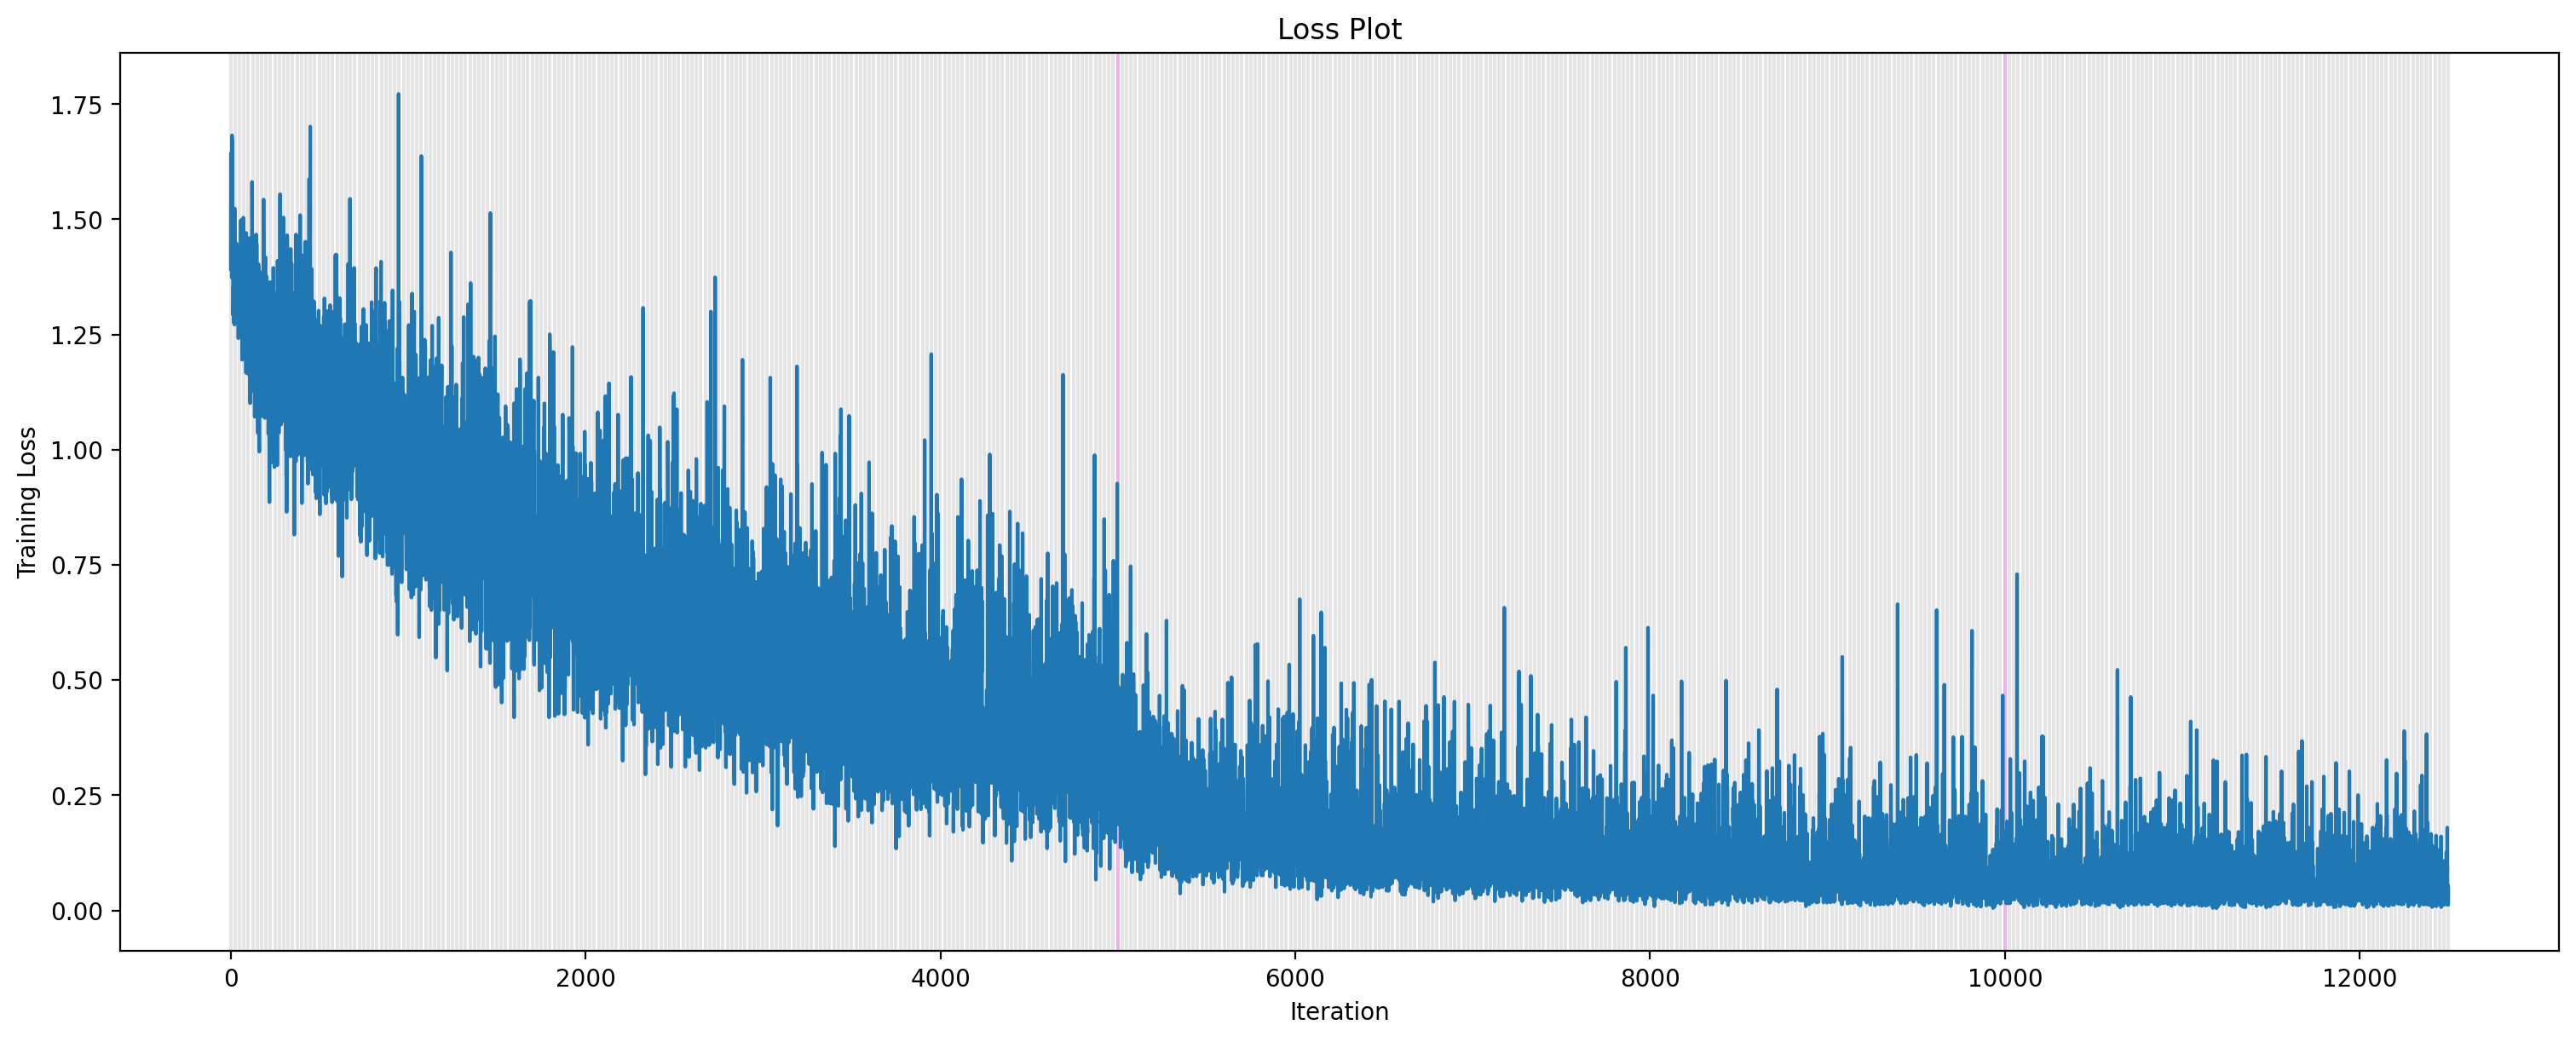

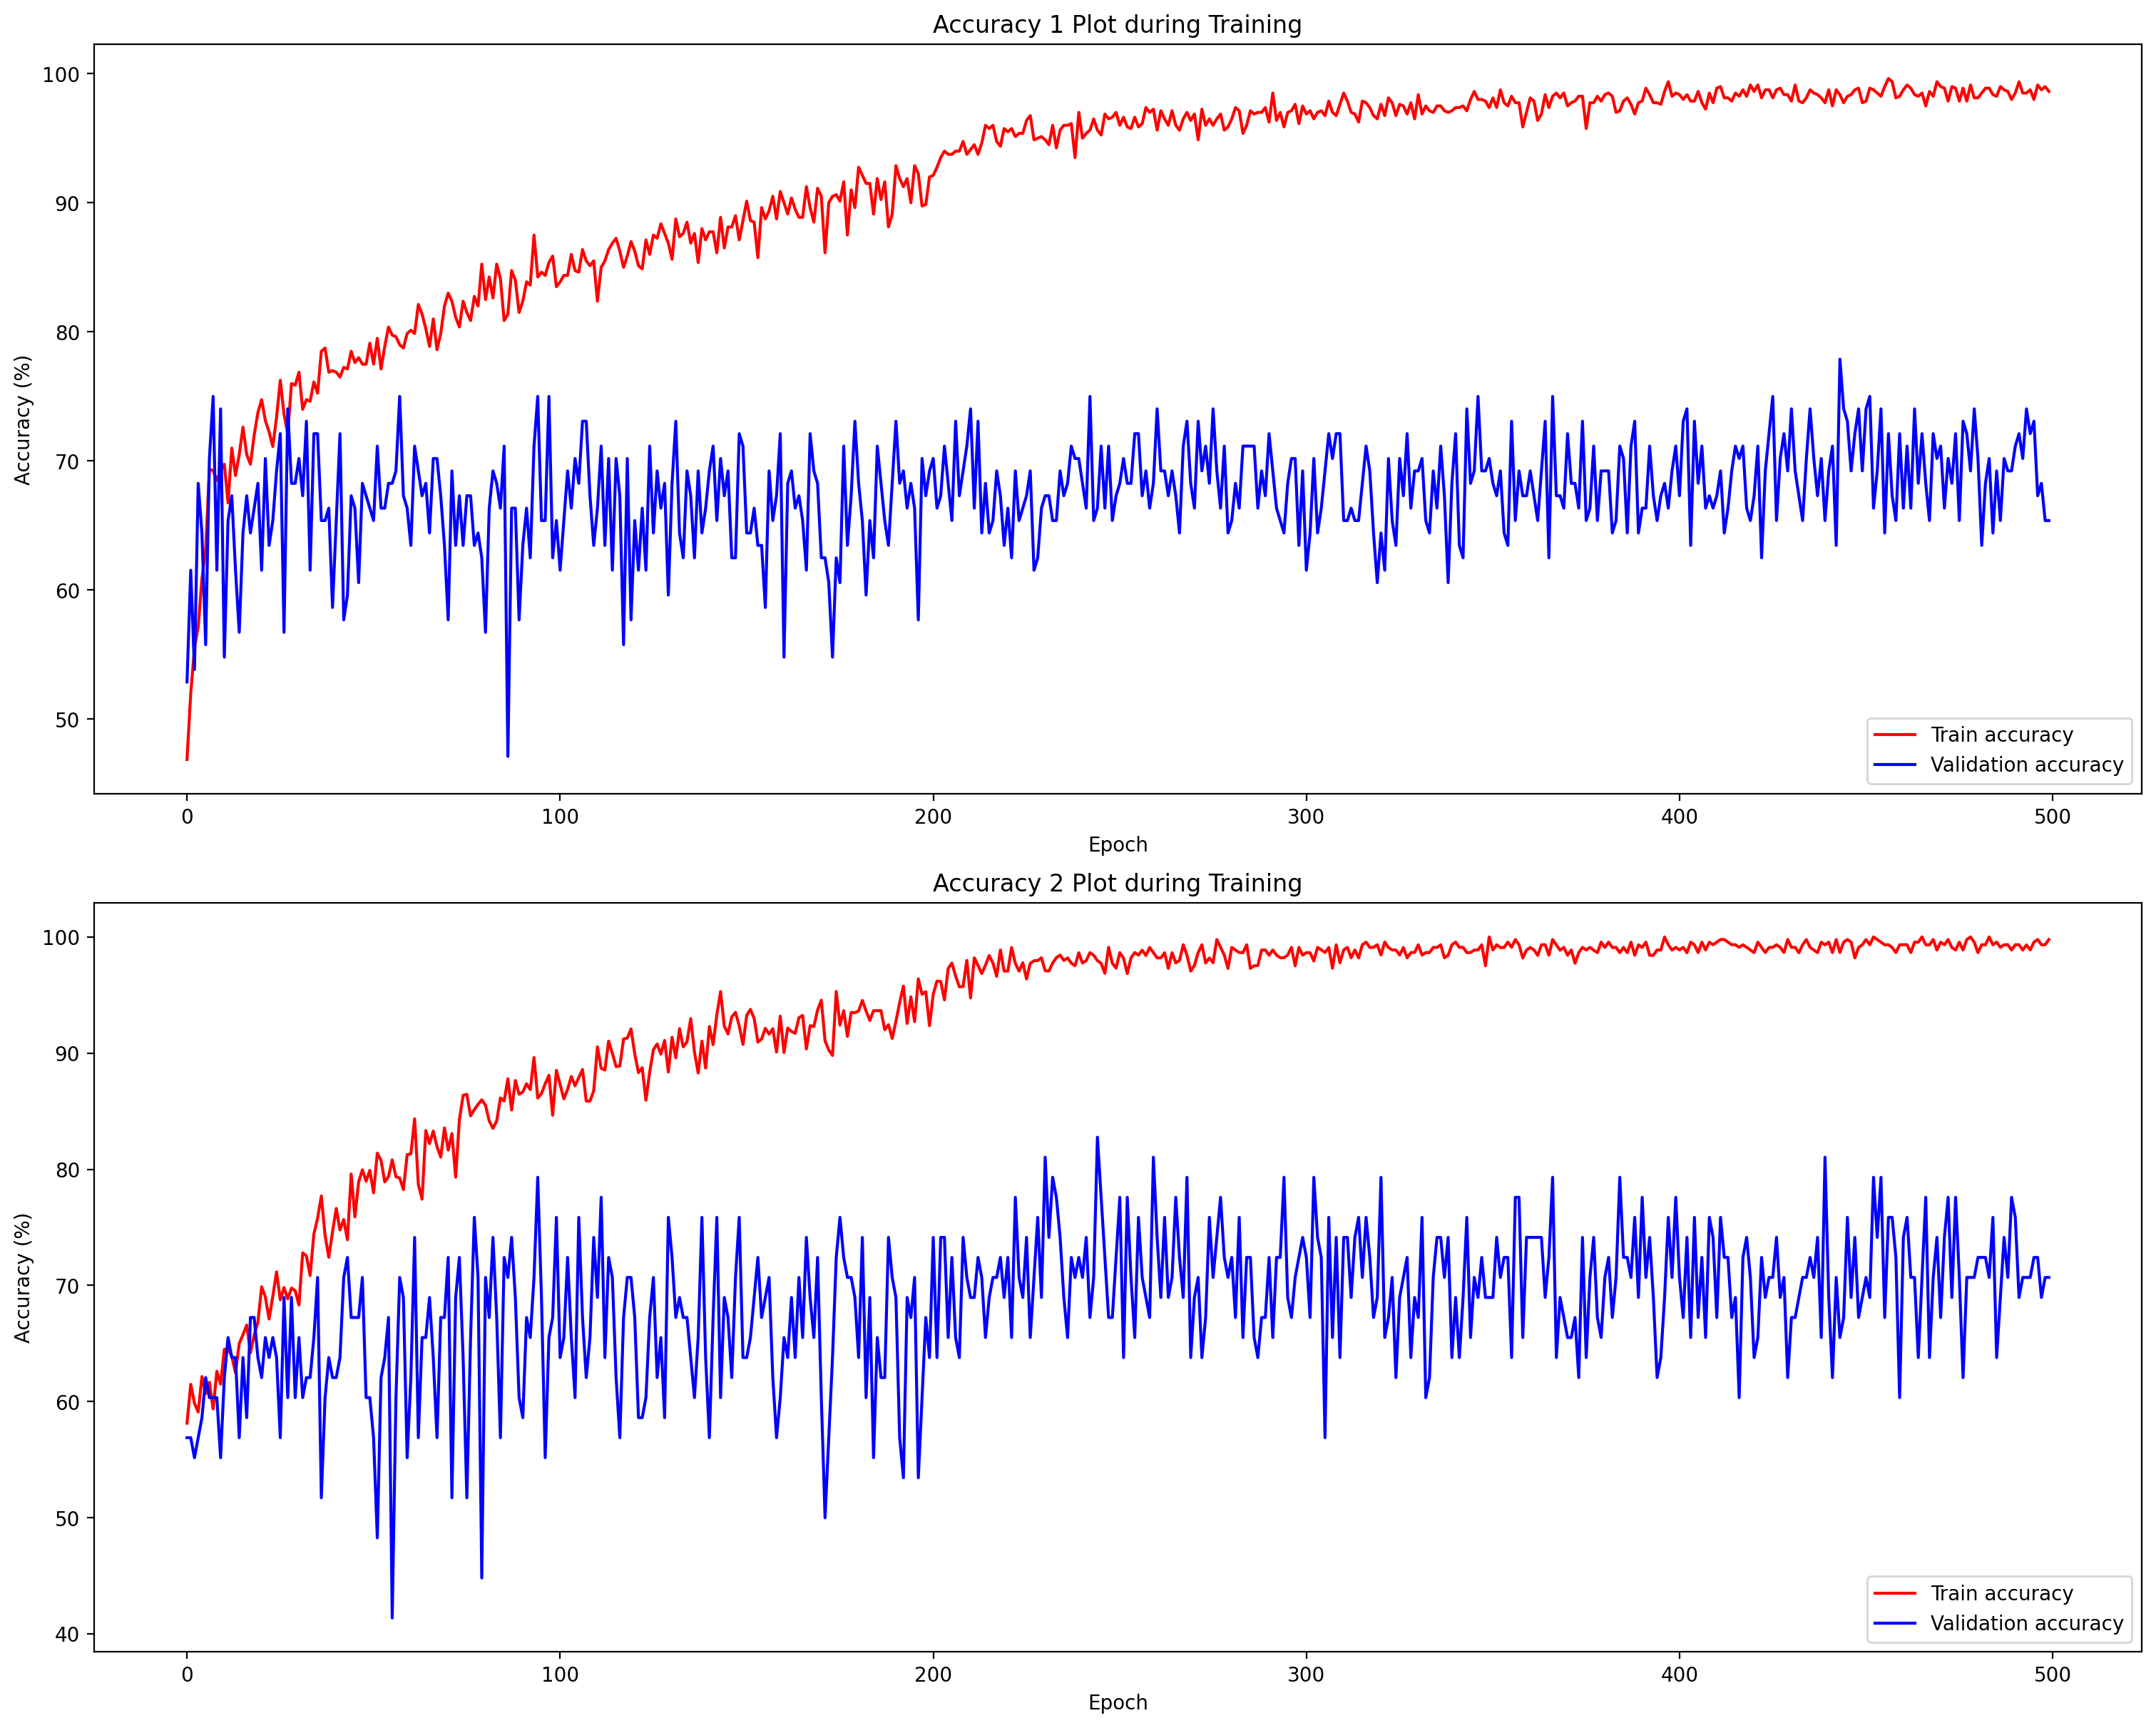

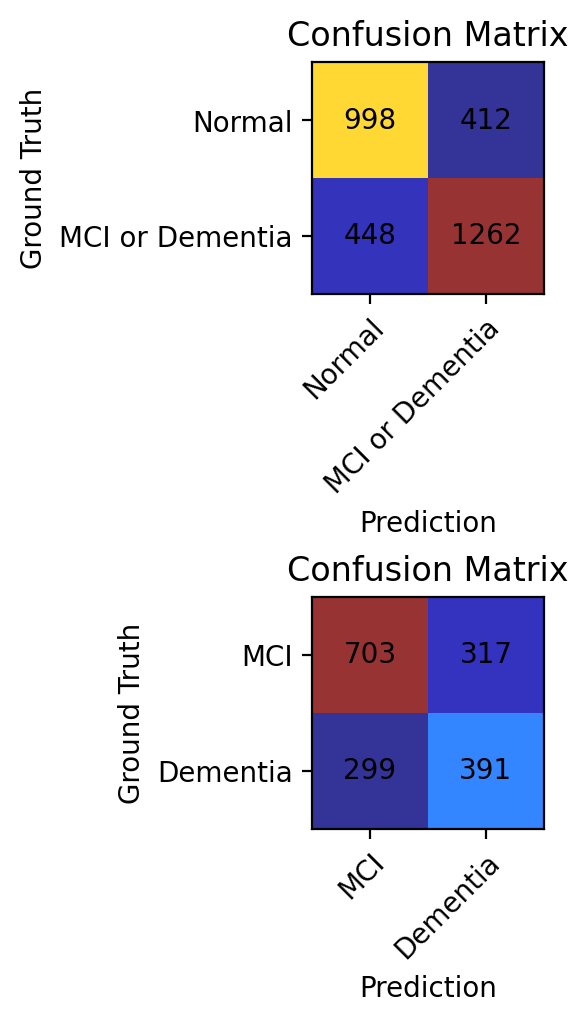

In [25]:
# reduce the learning after [lr_schedule_step] epochs by a factor of 10
n_epoch = 500
lr_schedule_step = 200
log_interval = len(train_loader) // 2

loss_history = []
train_acc_history = ([], [])
val_acc_history = ([], [])

model.reset_weights()
optimizer = optim.AdamW(model.parameters(), lr=10 ** best_log_lr, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_schedule_step, gamma=0.1)

print(f'{"*"*40} Training Starts {"*"*40}')

for epoch in tqdm(range(1, n_epoch + 1)):
    print(f'{"-"*30} Epoch {epoch:03d} / {n_epoch:03d}, Learning rate: {optimizer.param_groups[-1]["lr"]:.2e} {"-"*30}')
    
    # train
    loss, train_accuracy, train_confusion = train_one_epoch(model, optimizer, log_interval)
    loss_history.extend(loss)
    train_acc_history[0].append(train_accuracy[0])
    train_acc_history[1].append(train_accuracy[1])
    
    # validation
    val_accuracy, val_confusion = check_val_accuracy(model)
    val_acc_history[0].append(val_accuracy[0])
    val_acc_history[1].append(val_accuracy[1])
    
    # learning rate schedule
    scheduler.step()
    
    print()
    print(f'* Train accuracy: {train_accuracy[0]:.2f}% / {train_accuracy[1]:.2f}%, ')
    print(f'* Val   accuracy: {val_accuracy[0]:.2f}% / {val_accuracy[1]:.2f}%')
    print()
    
# test
test_accuracy, test_confusion, test_debug = check_test_accuracy(model, repeat=30)

print(f'{"*"*40} Training Ends {"*"*40}')
print(f'- Test accuracy: {test_accuracy:.2f}%')
print()
print('- Confusion matrix:\n', test_confusion)
print()

# draw the training loss plot
draw_loss_plot(loss_history)
draw_accuracy_history(train_acc_history, val_acc_history)

# draw the confusion matrix
draw_confusion(test_confusion)

In [ ]:
print('- Debug table:')
pprint.pp(test_debug, indent=2, width=100)

#### 1D CNN: ResNet-like model

In [26]:
class BasicResBlock(nn.Module):
    expansion: int = 1

    def __init__(self, c_in, c_out, kernel_size, stride) -> None:
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=c_in, out_channels=c_out, 
                               kernel_size=kernel_size, stride=stride, 
                               padding=kernel_size//2, bias=False)
        self.bn1 = nn.BatchNorm1d(c_out)

        self.conv2 = nn.Conv1d(in_channels=c_out, out_channels=c_out, 
                               kernel_size=kernel_size, stride=1, 
                               padding=kernel_size//2, bias=False)
        self.bn2 = nn.BatchNorm1d(c_out)

        self.relu = nn.ReLU(inplace=True)
        
        self.downsample = None
        if stride != 1 or c_in != c_out:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels=c_in, out_channels=c_out, 
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(c_out)
            )
                    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        if self.downsample is not None:
            identity = self.downsample(identity)
        x = self.relu(x + identity)
        
        return x

In [27]:
class BottleneckBlock(nn.Module):
    expansion: int = 4
        
    def __init__(self, c_in, c_out, kernel_size, stride) -> None:
        super().__init__()
        width = c_out
        self.conv1 = nn.Conv1d(in_channels=c_in, out_channels=width, 
                               kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm1d(width)

        self.conv2 = nn.Conv1d(in_channels=width, out_channels=width, 
                               kernel_size=kernel_size, stride=stride, 
                               padding=kernel_size//2, bias=False)
        self.bn2 = nn.BatchNorm1d(width)

        self.conv3 = nn.Conv1d(in_channels=width, out_channels=c_out*self.expansion, 
                               kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm1d(c_out*self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.downsample = None
        if stride != 1 or c_in != c_out*self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels=c_in, out_channels=c_out*self.expansion, 
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(c_out*self.expansion)
            )
                    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        if self.downsample is not None:
            identity = self.downsample(identity)
            
        x = self.relu(x + identity)
        
        return x

In [28]:
class ResNet(nn.Module):
    def __init__(self, 
                 block: Type[Union[BasicResBlock, BottleneckBlock]], 
                 conv_layers: List[int],
                 n_fc: int,
                 n_input=20,
                 n_output=3,
                 n_start=64,
                 kernel_size=9, 
                 use_age=True, 
                 final_pool='average') -> None:
        
        super().__init__()
        
        if final_pool not in {'average', 'max'}:
            raise ValueError("final_pool must be set to one of ['average', 'max']")        

        self.c_current = n_start
        self.use_age = use_age
        
        self.input_stage = nn.Sequential(
            nn.Conv1d(in_channels=n_input, out_channels=n_start, 
                      kernel_size=kernel_size*3, stride=2,
                      padding=(kernel_size*3)//2, bias=False),
            nn.BatchNorm1d(n_start), 
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3)
        )
        
        self.conv_stage1 = self._make_conv_layer(block, conv_layers[0], n_start, kernel_size, stride=5)
        self.conv_stage2 = self._make_conv_layer(block, conv_layers[1], n_start*2, kernel_size, stride=5)
        self.conv_stage3 = self._make_conv_layer(block, conv_layers[2], n_start*4, kernel_size, stride=5)
        self.conv_stage4 = self._make_conv_layer(block, conv_layers[3], n_start*8, kernel_size, stride=5)
        
        if final_pool == 'average':
            self.final_pool = nn.AdaptiveAvgPool1d(1)
        elif final_pool == 'max':
            self.final_pool = nn.AdaptiveMaxPool1d(1)
        
        fc_layers = []        
        if self.use_age:
            self.c_current = self.c_current + 1
        
        for l in range(n_fc):
            layer = nn.Sequential(nn.Linear(self.c_current, self.c_current // 2, bias=False),
                                  nn.Dropout(p=0.1),
                                  nn.BatchNorm1d(self.c_current // 2), 
                                  nn.ReLU())
            self.c_current = self.c_current // 2
            fc_layers.append(layer)
        fc_layers.append(nn.Linear(self.c_current, n_output))
        self.fc_stage = nn.Sequential(*fc_layers)
        
    def reset_weights(self):
        for m in self.modules():
            if hasattr(m, 'reset_parameters'):
                m.reset_parameters()
        
    def _make_conv_layer(self, block: Type[Union[BasicResBlock, BottleneckBlock]], 
                         n_block: int, c_out: int, kernel_size: int, stride: int = 1) -> nn.Sequential:
        layers = []
        c_in = self.c_current
        layers.append(block(c_in, c_out, kernel_size, stride=1))

        c_in = c_out * block.expansion
        self.c_current = c_in
        for _ in range(1, n_block):
            layers.append(block(c_in, c_out, kernel_size, stride=1))
            
        layers.append(nn.MaxPool1d(kernel_size=stride))
            
        return nn.Sequential(*layers)

    def forward(self, x, age, print_shape=False):
        x = self.input_stage(x)
        
        x = self.conv_stage1(x)
        x = self.conv_stage2(x)
        x = self.conv_stage3(x)
        x = self.conv_stage4(x)

        if print_shape:
            print('Shape right before squeezing:', x.shape)

        x = self.final_pool(x).squeeze()
        if self.use_age:
            x = torch.cat((x, age.reshape(-1, 1)), dim=1)
            
        x = self.fc_stage(x)
        
        return x
        # return F.log_softmax(x, dim=2)

In [29]:
model = ResNet(block=BottleneckBlock, 
               conv_layers=[2, 2, 2, 2], 
               n_fc=2, 
               n_input=20, 
               n_output=3, 
               n_start=64,
               kernel_size=9, 
               use_age=True, 
               final_pool='max')
model = model.to(device, dtype=torch.float32)
print(model)
print()

# tensorboard visualization
visualize_network_tensorboard(model, 'ResNet-like')

# number of parameters
n = count_parameters(model)
print(f'The Number of parameters of the model: {n:,}')

ResNet(
  (input_stage): Sequential(
    (0): Conv1d(20, 64, kernel_size=(27,), stride=(2,), padding=(13,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_stage1): Sequential(
    (0): BottleneckBlock(
      (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv1d(64, 256, kernel_size=(1,), stride=(1,), bias=False)
      (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv1d(64, 256, kernel_size=(1,), stride

In [30]:
# record = learning_rate_search(model, 
#                               min_log_lr=-4.5, 
#                               max_log_lr=-1.4, 
#                               trials=500, 
#                               epochs=3)
# draw_learning_rate_record(record)
# best_log_lr = record[np.argmax(np.array([v for lr, v in record]))][0]

best_log_lr = -3.5
print('best_log_lr:', best_log_lr)

best_log_lr: -3.5


**************************************** Training Starts ****************************************


  0%|          | 0/500 [00:00<?, ?it/s]

------------------------------ Epoch 001 / 500, Learning rate: 3.16e-04 ------------------------------
- Iter 012 / 025, Loss: 1.202692
- Iter 024 / 025, Loss: 1.330617

* Train accuracy: 49.38% / 59.68%, 
* Val   accuracy: 54.81% / 60.34%

------------------------------ Epoch 002 / 500, Learning rate: 3.16e-04 ------------------------------
- Iter 012 / 025, Loss: 1.371419
- Iter 024 / 025, Loss: 1.366044

* Train accuracy: 48.12% / 62.28%, 
* Val   accuracy: 46.15% / 63.79%

------------------------------ Epoch 003 / 500, Learning rate: 3.16e-04 ------------------------------
- Iter 012 / 025, Loss: 1.320349
- Iter 024 / 025, Loss: 1.358007

* Train accuracy: 46.88% / 60.59%, 
* Val   accuracy: 48.08% / 62.07%

------------------------------ Epoch 004 / 500, Learning rate: 3.16e-04 ------------------------------
- Iter 012 / 025, Loss: 1.476151
- Iter 024 / 025, Loss: 1.357134

* Train accuracy: 47.38% / 59.37%, 
* Val   accuracy: 50.00% / 58.62%

------------------------------ Epoch

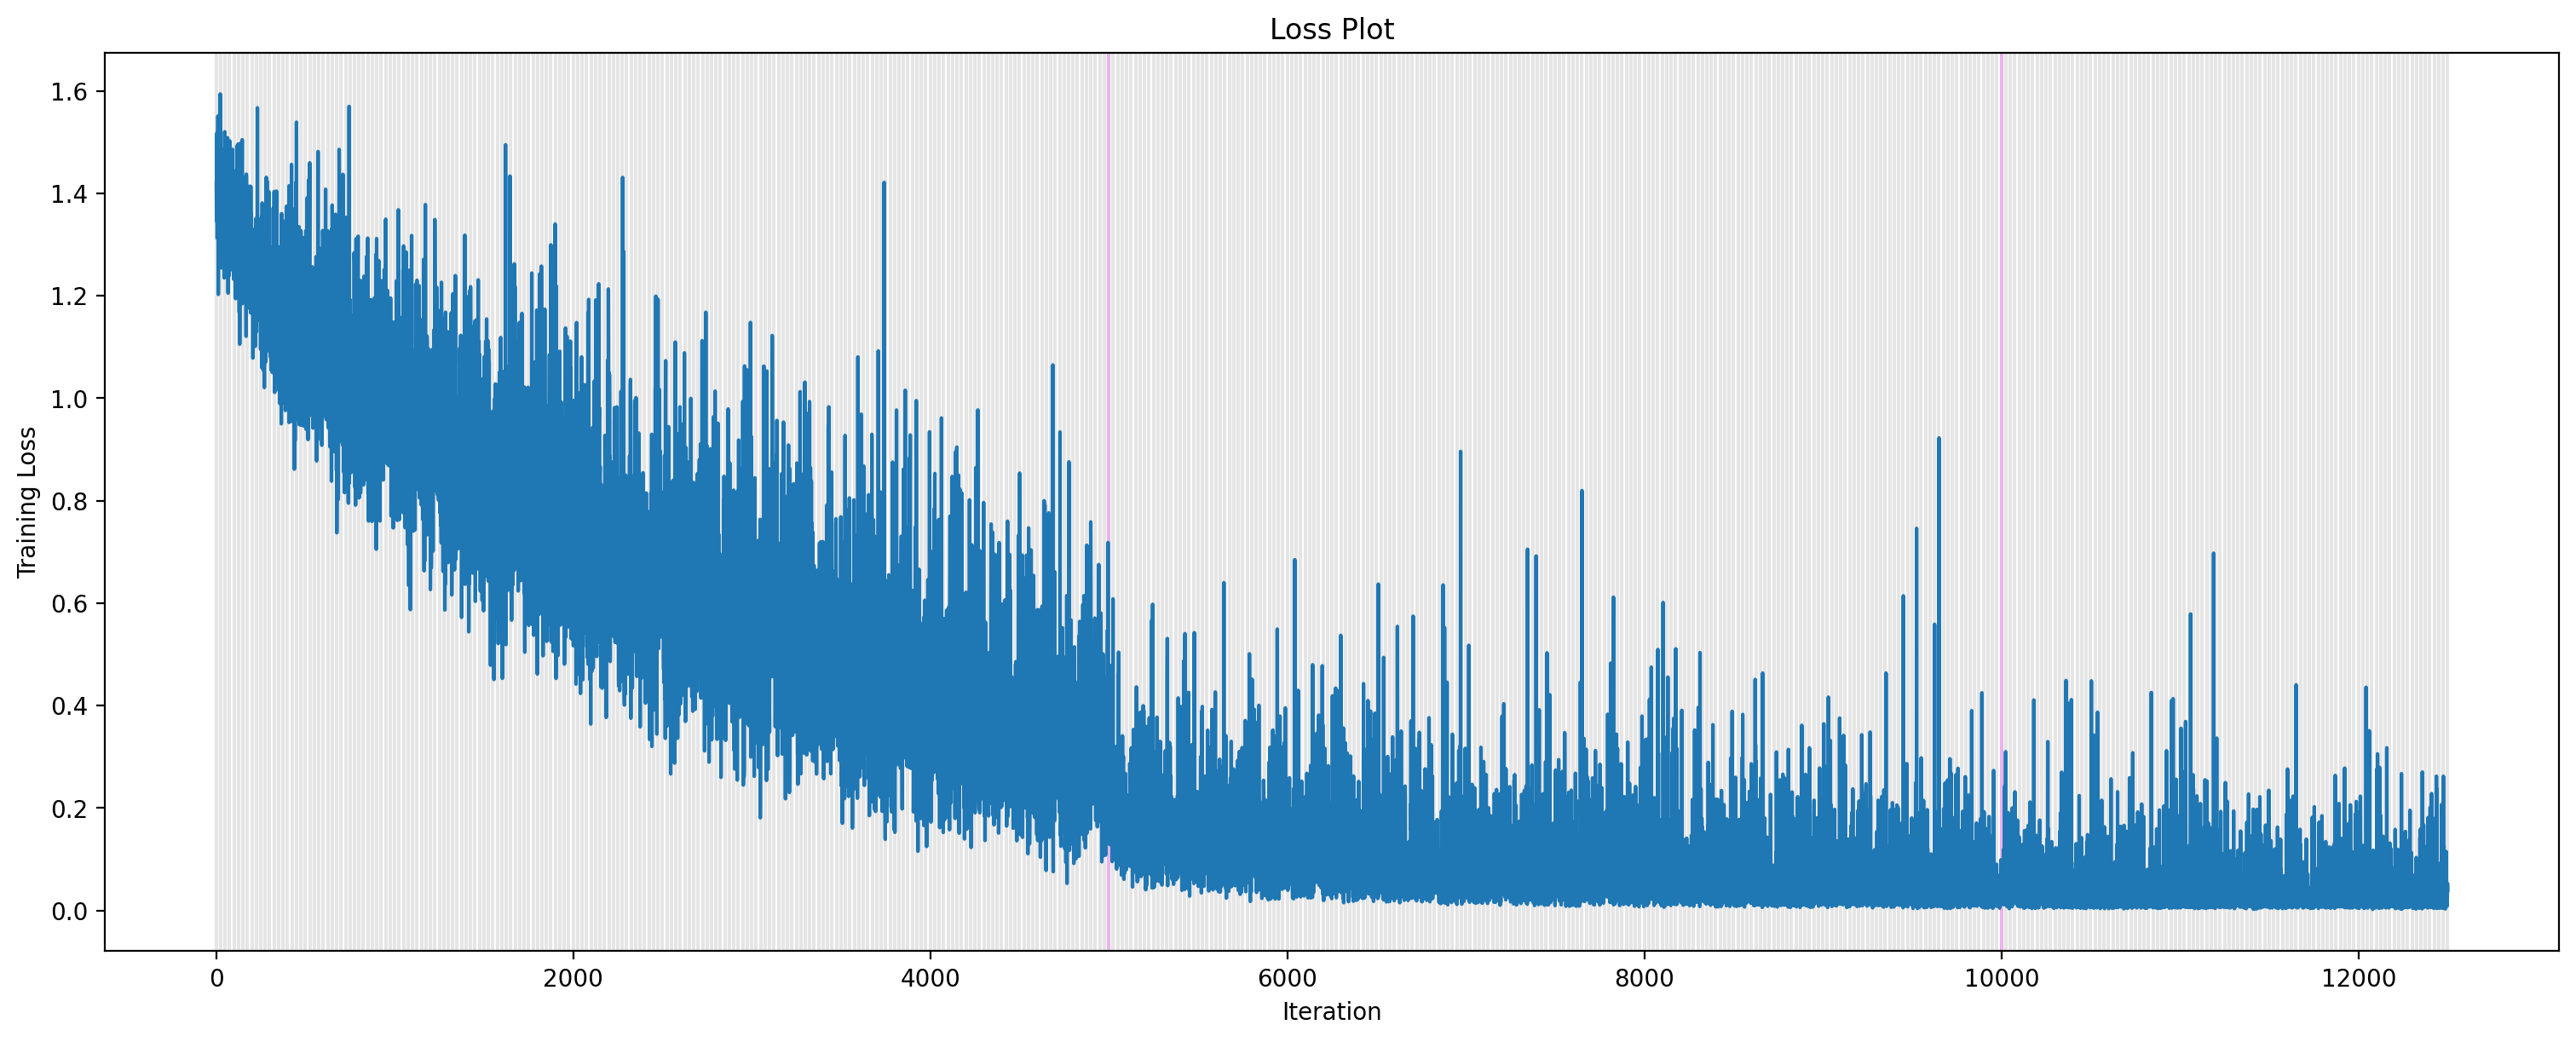

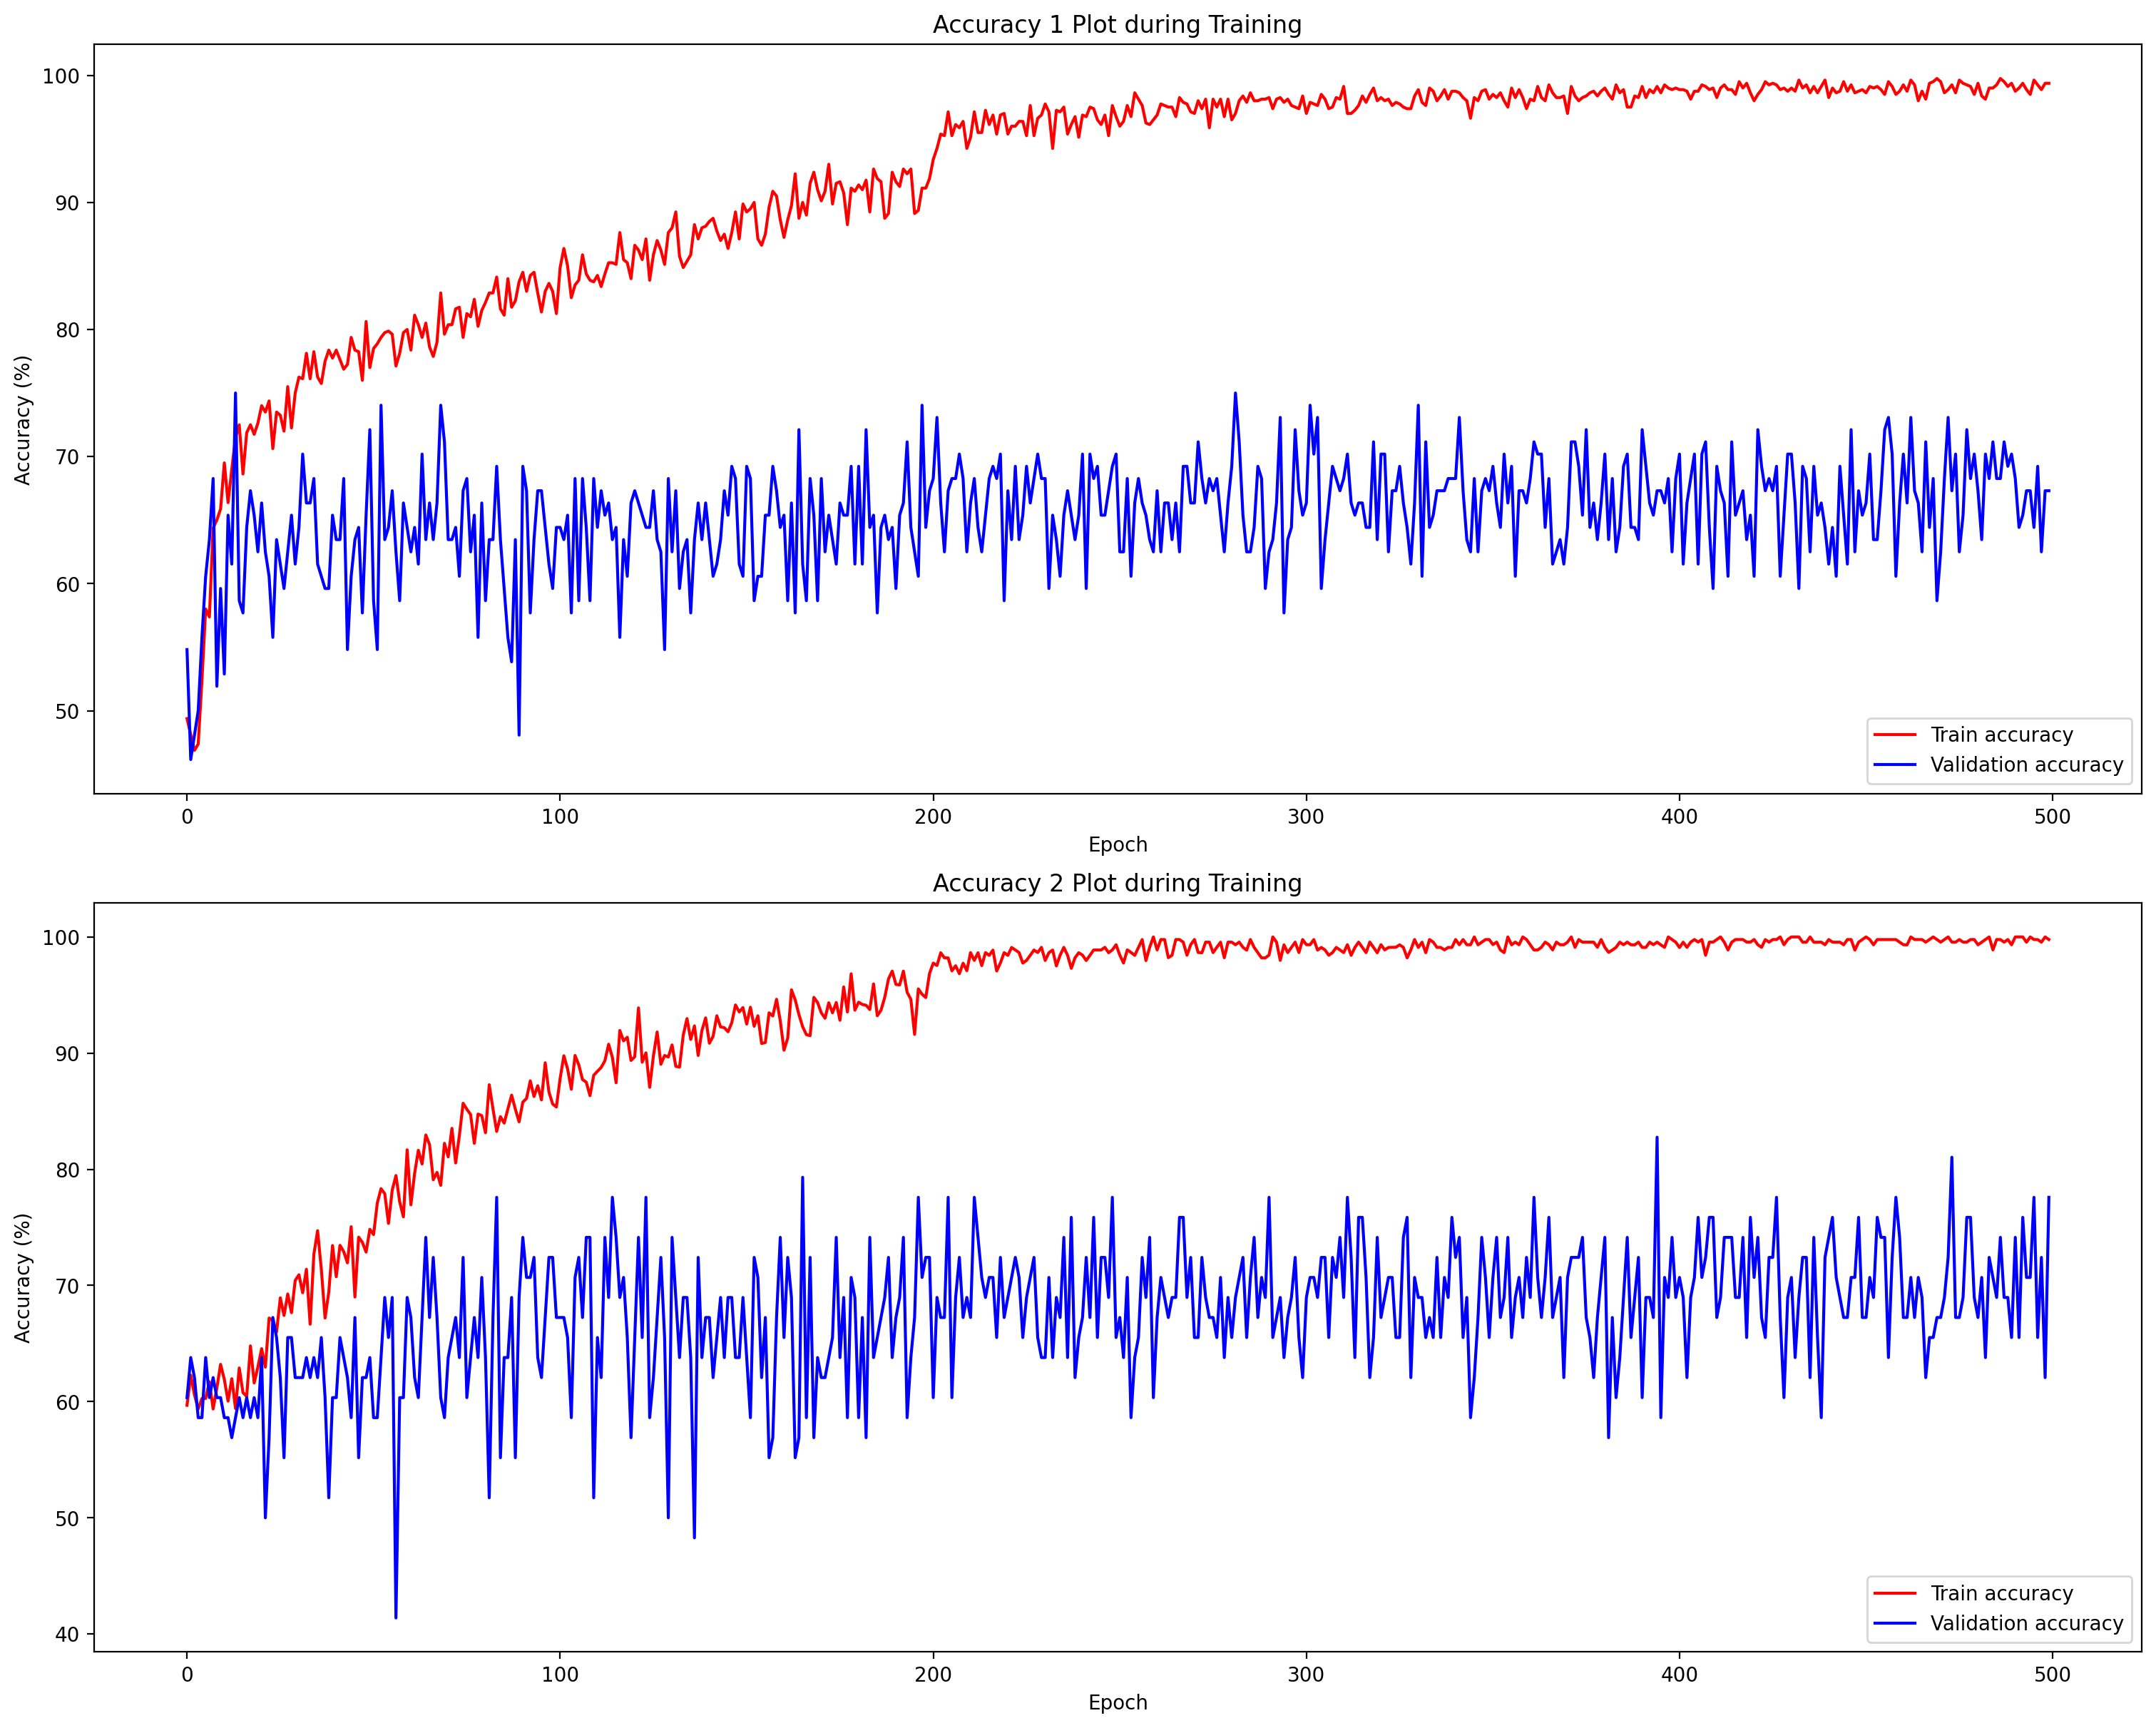

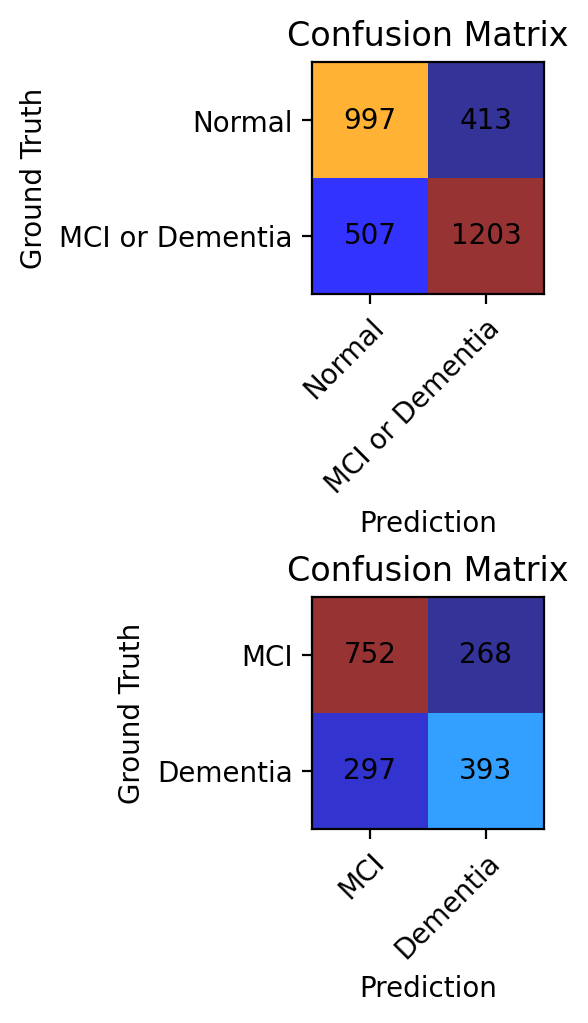

In [31]:
# reduce the learning after [lr_schedule_step] epochs by a factor of 10
n_epoch = 500
lr_schedule_step = 200
log_interval = len(train_loader) // 2

loss_history = []
train_acc_history = ([], [])
val_acc_history = ([], [])

model.reset_weights()
optimizer = optim.AdamW(model.parameters(), lr=10 ** best_log_lr, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_schedule_step, gamma=0.1)

print(f'{"*"*40} Training Starts {"*"*40}')

for epoch in tqdm(range(1, n_epoch + 1)):
    print(f'{"-"*30} Epoch {epoch:03d} / {n_epoch:03d}, Learning rate: {optimizer.param_groups[-1]["lr"]:.2e} {"-"*30}')
    
    # train
    loss, train_accuracy, train_confusion = train_one_epoch(model, optimizer, log_interval)
    loss_history.extend(loss)
    train_acc_history[0].append(train_accuracy[0])
    train_acc_history[1].append(train_accuracy[1])
    
    # validation
    val_accuracy, val_confusion = check_val_accuracy(model)
    val_acc_history[0].append(val_accuracy[0])
    val_acc_history[1].append(val_accuracy[1])
    
    # learning rate schedule
    scheduler.step()
    
    print()
    print(f'* Train accuracy: {train_accuracy[0]:.2f}% / {train_accuracy[1]:.2f}%, ')
    print(f'* Val   accuracy: {val_accuracy[0]:.2f}% / {val_accuracy[1]:.2f}%')
    print()
    
# test
test_accuracy, test_confusion, test_debug = check_test_accuracy(model, repeat=30)

print(f'{"*"*40} Training Ends {"*"*40}')
print(f'- Test accuracy: {test_accuracy:.2f}%')
print()
print('- Confusion matrix:\n', test_confusion)
print()

# draw the training loss plot
draw_loss_plot(loss_history)
draw_accuracy_history(train_acc_history, val_acc_history)

# draw the confusion matrix
draw_confusion(test_confusion)

In [ ]:
print('- Debug table:')
pprint.pp(test_debug, indent=2, width=100)